# 10X scRNA-seq data Xenopus Laevis - DE IVF/NT and ON-memory genes

March 13, 2020 Jonathan Fiorentino

November, 20, 2020: 

1. GO (look at the notebook for outlier identification)

2. Bulk in-silico ON- and OFF- memory genes (not essential)

4. Comment and reorder the code

Note the definitions of ON- and OFF- memory genes from Eva's paper:

- ON-memory: FDR Donor/IVF < 0.05, logFCDonor/IVF > 0, FDR NT/IVF < 0.05, logFC NT/IVF > 0, RPKMDonor > 1 (note that RPKM Donor > 1 means in all donor samples) 

- OFF-memory: FDR Donor/IVF < 0.05, logFCDonor/IVF < 0, FDR NT/IVF < 0.05, logFC NT/IVF < 0

In order to give a new definition of ON- and OFF-memory genes from scRNA-seq data, we will need to use the logFC and FDR computed with edgeR and already present in the bulk RNA-seq data.

Perform comparisons between the sets of ON- (OFF-) memory genes, both when looking at the enrichment for ON-memory genes from bulk and when defining them from the scRNA-seq data, for instance heatmap of the Jaccard index between the sets of genes for the different clusters.

When looking at the enrichment, we can show as bar plot with the number of newly defined ON- (OFF-) memory genes and the number of bulk ON- (OFF-) memory genes per cell type.

In [1]:
%matplotlib inline

In [2]:
library(Seurat)
library(ggplot2)
library(cowplot)

#Load the data
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered_no_out.rds")

# Functions

In [3]:
library("DESeq2")
library("scran")
library("BiocParallel")
register(MulticoreParam(4))

PreFilter.tot <-function(sce){    
    dds <- convertTo(sce, type="DESeq2")
    dds$exp <- sce$exp
    dds$isnt <- sce$isnt
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]
    rownames(dds)
    }

selFun <- function(gList){
    gList<0.05
}

topGO.XeLaev <- function(geneList,gene2GO.Xen,description.string){
    GOdata <- new("topGOdata",
               description = description.string,
               ontology = "BP",
               allGenes = geneList,
               geneSel = selFun,
               annot = annFUN.gene2GO,
               nodeSize = 5,
               gene2GO = gene2GO.Xen)
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultKS <- runTest(GOdata, algorithm = "classic", statistic = "ks")
    resultKS.elim <- runTest(GOdata, algorithm = "elim", statistic = "ks")
    allRes <- GenTable(GOdata, classicFisher = resultFisher,
                    classicKS = resultKS, elimKS = resultKS.elim,
                    orderBy = "elimKS", ranksOf = "classicFisher", topNodes = 5)
}

DE_IVF_NT <-function(sce,i){
    cl.lab <- (sce$seurat_clusters == i)
    
    dds <- convertTo(sce[,cl.lab], type="DESeq2")
    dds$exp <- sce[,cl.lab]$exp
    dds$isnt <- sce[,cl.lab]$isnt
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]
    print(dds)
    dds <- DESeqDataSet(dds, design = ~ exp + isnt)                     
    dds <- DESeq(dds,parallel=TRUE)
    res <- results(dds, contrast=c("isnt","NT","IVF"),parallel=TRUE)
    res <- res[order(res$padj, decreasing = F),]
    #res <- res[order(res$log2FoldChange, decreasing = T),]
    res <- res[!is.na(res$padj),]
    #res <- res[res$padj< 0.1,]
    res <- as.data.frame.matrix(res)
    res
    }

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max

# DE IVF/NT in each cluster

We use DESeq2 to perform differential expression between IVF and NT cells in each cluster, controlling for the effect of the experiment 

In [4]:
# #Load the raw data
# xenopus.combined.raw <- readRDS(file = "xenopus_combined_and_clustered_raw_no_out.rds")
# xenopus.combined.raw$seurat_clusters <- xenopus.combined$seurat_clusters
# xenopus.combined.raw.sce <- as.SingleCellExperiment(xenopus.combined.raw)
# saveRDS(xenopus.combined.raw.sce, file = "xenopus_combined_raw_sce_no_out.rds")

This is the code that I use for DE between IVF and NT in each cluster controlling for the effect of the experiment (I ran it on the server)

In [5]:
# res0 <- DE_IVF_NT(xenopus.combined.raw.sce,"0")
# res1 <- DE_IVF_NT(xenopus.combined.raw.sce,"1")
# res2 <- DE_IVF_NT(xenopus.combined.raw.sce,"2")
# res3 <- DE_IVF_NT(xenopus.combined.raw.sce,"3")
# res4 <- DE_IVF_NT(xenopus.combined.raw.sce,"4")
# res5 <- DE_IVF_NT(xenopus.combined.raw.sce,"5")
# res6 <- DE_IVF_NT(xenopus.combined.raw.sce,"6")
# res7 <- DE_IVF_NT(xenopus.combined.raw.sce,"7")
# res8 <- DE_IVF_NT(xenopus.combined.raw.sce,"8")
# res9 <- DE_IVF_NT(xenopus.combined.raw.sce,"9")

In [4]:
# Load the results of the DE test in each cluster
res0 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res0.csv')
res1 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res1.csv')
res2 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res2.csv')
res3 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res3.csv')
res4 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res4.csv')
res5 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res5.csv')
res6 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res6.csv')
res7 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res7.csv')
res8 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res8.csv')
res9 <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res9.csv')

In [5]:
results.DE <- c(res0,res1,res2,res3,res4,res5,res6,res7,res8,res9)

# Define ON- and OFF- memory genes from scRNA-seq

I recall the definitions of ON- and OFF- memory genes

- ON-memory: FDR Donor/IVF < 0.05, logFCDonor/IVF > 0, FDR NT/IVF < 0.05, logFC NT/IVF > 0, RPKMDonor > 1 (note that RPKM Donor > 1 means in all donor samples) 

- OFF-memory: FDR Donor/IVF < 0.05, logFCDonor/IVF < 0, FDR NT/IVF < 0.05, logFC NT/IVF < 0

We will consider as candidate genes those DE between donor and IVF samples, and for the candidate ON-memory we will also consider the filter on the RPKM in donor.

In [8]:
# First step: from the bulk RNA-seq data, select the genes that could be ON- or OFF-
# memory genes
import pandas as pd

bulk_data=pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/bulk_RNA_seq.csv")
bulk_data = bulk_data.set_index('Row.names')

new_names=[]

for i in list(bulk_data.index):
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        new_names.append(lst[0])
    else:
        new_names.append(lst[1])
        
bulk_data.index=new_names

bulk_data_ON=bulk_data[bulk_data['FDR=IVF_vs_donor'] < 0.05]
bulk_data_ON=bulk_data_ON[bulk_data_ON['logFC=IVF_vs_donor'] < 0]
# bulk_data_ON=bulk_data_ON[bulk_data_ON['FDR=NT_vs_IVF'] < 0.05]
# bulk_data_ON=bulk_data_ON[bulk_data_ON['logFC=NT_vs_IVF'] > 0]
bulk_data_ON=bulk_data_ON[(bulk_data_ON[['RPKM_donor1','RPKM_donor2','RPKM_donor3']] > 1).all(1)]

bulk_data_OFF=bulk_data[bulk_data['FDR=IVF_vs_donor'] < 0.05]
bulk_data_OFF=bulk_data_OFF[bulk_data_OFF['logFC=IVF_vs_donor'] > 0]
# bulk_data_OFF=bulk_data_OFF[bulk_data_OFF['FDR=NT_vs_IVF'] < 0.05]
# bulk_data_OFF=bulk_data_OFF[bulk_data_OFF['logFC=NT_vs_IVF'] < 0]

# Select the ON- and OFF- memory genes from the bulk RNA-seq data
filtered_bulk_data_ON=bulk_data_ON[bulk_data_ON['FDR=NT_vs_IVF'] < 0.05]
filtered_bulk_data_ON=filtered_bulk_data_ON[filtered_bulk_data_ON['logFC=NT_vs_IVF'] > 0]

filtered_bulk_data_OFF=bulk_data_OFF[bulk_data_OFF['FDR=NT_vs_IVF'] < 0.05]
filtered_bulk_data_OFF=filtered_bulk_data_OFF[filtered_bulk_data_OFF['logFC=NT_vs_IVF'] < 0]

In [9]:
DE_IVF_NT_folder='/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/'

# Define ON- and OFF- memory genes from scRNA-seq data

sc_ON_memory=[]
sc_OFF_memory=[]
sc_ON_memory_logFC_1=[]
sc_OFF_memory_logFC_1=[]

for i in range(10):
    DE_results=pd.read_csv(DE_IVF_NT_folder+'res'+str(i)+'.csv',index_col=0)
    # Consider significant genes
    DE_results_sign=DE_results[DE_results['padj'] < 0.05]
    
    # Separate up and down regulated genes (NT/IVF)
    DE_results_up=DE_results_sign[DE_results_sign['log2FoldChange']>0]
    DE_results_down=DE_results_sign[DE_results_sign['log2FoldChange']<0]
    
    DE_results_up_logFC_1=DE_results_sign[DE_results_sign['log2FoldChange']>1]
    DE_results_down_logFC_1=DE_results_sign[DE_results_sign['log2FoldChange']< -1]
    
    new_ON_mem=list(set(list(DE_results_up.index)) & set(list(bulk_data_ON.index)))
    new_OFF_mem=list(set(list(DE_results_down.index)) & set(list(bulk_data_OFF.index)))
    
    scON=DE_results_up.loc[new_ON_mem]
    scON=scON[['log2FoldChange','padj']]
    scON=scON.sort_values('padj')
    scOFF=DE_results_down.loc[new_OFF_mem]
    scOFF=scOFF[['log2FoldChange','padj']]
    scOFF=scOFF.sort_values('padj')
    
    # Save ON and OFF memory genes for each cluster
    scON.to_excel(DE_IVF_NT_folder+'scON_cluster_'+str(i)+'.xlsx')
    scOFF.to_excel(DE_IVF_NT_folder+'scOFF_cluster_'+str(i)+'.xlsx')
    
    new_ON_mem_inters_bulk=list(set(list(DE_results_up.index)) & set(list(filtered_bulk_data_ON.index)))
    new_OFF_mem_inters_bulk=list(set(list(DE_results_down.index)) & set(list(filtered_bulk_data_OFF.index)))
    
    scON_inters_bulk=DE_results_up.loc[new_ON_mem_inters_bulk]
    scON_inters_bulk=scON_inters_bulk[['log2FoldChange','padj']]
    scON_inters_bulk=scON_inters_bulk.sort_values('padj')
    scOFF_inters_bulk=DE_results_down.loc[new_OFF_mem_inters_bulk]
    scOFF_inters_bulk=scOFF_inters_bulk[['log2FoldChange','padj']]
    scOFF_inters_bulk=scOFF_inters_bulk.sort_values('padj')
    
    # Save ON and OFF memory genes for each cluster intersected with bulk memory genes
    scON_inters_bulk.to_excel(DE_IVF_NT_folder+'intersection_bulk_scON_cluster_'+str(i)+'.xlsx')
    scOFF_inters_bulk.to_excel(DE_IVF_NT_folder+'intersection_bulk_scOFF_cluster_'+str(i)+'.xlsx')
    
    new_ON_mem_logFC_1=list(set(list(DE_results_up_logFC_1.index)) & set(list(bulk_data_ON.index)))
    new_OFF_mem_logFC_1=list(set(list(DE_results_down_logFC_1.index)) & set(list(bulk_data_OFF.index)))
    
    print('ON',i,len(DE_results_up),len(bulk_data_ON),len(new_ON_mem))
    print('OFF',i,len(DE_results_down),len(bulk_data_OFF),len(new_OFF_mem))
    
    sc_ON_memory.append(new_ON_mem)
    sc_OFF_memory.append(new_OFF_mem)
    
    sc_ON_memory_logFC_1.append(new_ON_mem_logFC_1)
    sc_OFF_memory_logFC_1.append(new_OFF_mem_logFC_1)

ON 0 2744 6532 443
OFF 0 1305 7315 387
ON 1 2493 6532 364
OFF 1 1751 7315 323
ON 2 1744 6532 181
OFF 2 1689 7315 346
ON 3 1176 6532 211
OFF 3 642 7315 151
ON 4 2083 6532 258
OFF 4 1659 7315 326
ON 5 968 6532 199
OFF 5 725 7315 264
ON 6 547 6532 167
OFF 6 560 7315 233
ON 7 935 6532 204
OFF 7 728 7315 203
ON 8 1311 6532 228
OFF 8 580 7315 159
ON 9 2065 6532 298
OFF 9 1327 7315 327


In [16]:
for i in range(10):
    ON=pd.read_excel(DE_IVF_NT_folder+'scON_cluster_'+str(i)+'.xlsx',index_col=0)
    OFF=pd.read_excel(DE_IVF_NT_folder+'scOFF_cluster_'+str(i)+'.xlsx',index_col=0)
    
    print(len(ON),len(OFF))

443 387
364 323
181 346
211 151
258 326
199 264
167 233
204 203
228 159
298 327


## Plots

1. Heatmap of Jaccard index for ON and OFF memory genes (rows and columns are the cell types)

2. Upset plot for ON- and OFF- memory genes

3. Bar plots with number of ON- and OFF- memory genes in each cell type

In [21]:
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def jaccard_distance(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return 1.0 - float(len(s1.intersection(s2)) / len(s1.union(s2)))

# l is a list of lists
def jaccard_heatmap(l,title_lab,x_axis_labels,y_axis_labels,anal_label):
    
    jaccardMat=np.array([[jaccard_distance(i,j) for i in l] for j in l])
    np.fill_diagonal(jaccardMat, np.nan)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Overlap between sets of sc'+title_lab+'memory genes'+anal_label)
    sns.heatmap(jaccardMat, cmap="YlGnBu",annot=True,ax=ax,
                cbar_kws={'label': 'Jaccard distance'},xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
    plt.show(),plt.close()

#ax[0].set_xlabel('Absorbing cell')
#ax[0].set_ylabel('Releasing cell')

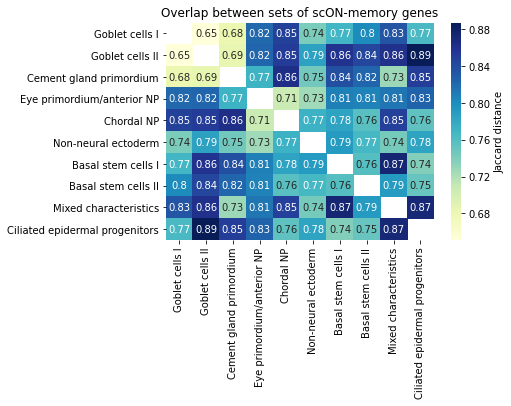

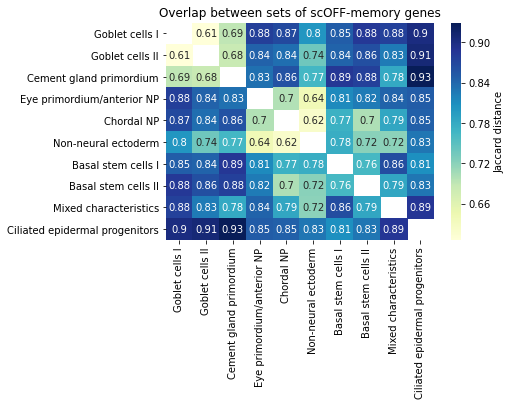

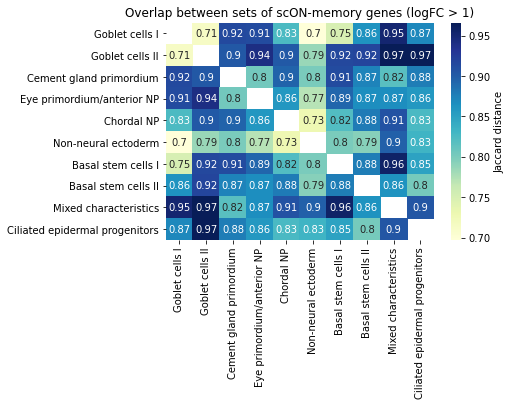

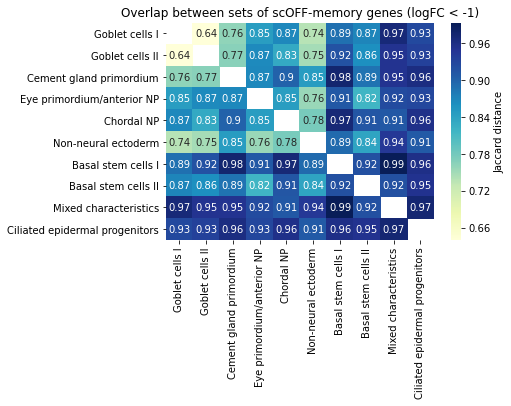

In [22]:
CT_names=['Non-neural ectoderm','Goblet cells I','Goblet cells II','Basal stem cells I',
          'Cement gland primordium','Eye primordium/anterior NP','Chordal NP',
          'Ciliated epidermal progenitors','Basal stem cells II','Mixed characteristics']

order=[1,2,4,5,6,0,3,8,9,7]

sc_ON_memory_ordered=[sc_ON_memory[k] for k in order]
sc_OFF_memory_ordered=[sc_OFF_memory[k] for k in order]

sc_ON_memory_logFC_1_ordered=[sc_ON_memory_logFC_1[k] for k in order]
sc_OFF_memory_logFC_1_ordered=[sc_OFF_memory_logFC_1[k] for k in order]

CT_names_ordered=[CT_names[h] for h in order]

jaccard_heatmap(sc_ON_memory_ordered,title_lab='ON-',x_axis_labels=CT_names_ordered,
                y_axis_labels=CT_names_ordered,anal_label='')

jaccard_heatmap(sc_OFF_memory_ordered,title_lab='OFF-',x_axis_labels=CT_names_ordered,
                y_axis_labels=CT_names_ordered,anal_label='')

jaccard_heatmap(sc_ON_memory_logFC_1_ordered,title_lab='ON-',x_axis_labels=CT_names_ordered,
                y_axis_labels=CT_names_ordered,anal_label=' (logFC > 1)')

jaccard_heatmap(sc_OFF_memory_logFC_1_ordered,title_lab='OFF-',x_axis_labels=CT_names_ordered,
                y_axis_labels=CT_names_ordered,anal_label=' (logFC < -1)')

In [23]:
length_ON_memory=[len(i) for i in sc_ON_memory_ordered]
length_OFF_memory=[len(i) for i in sc_OFF_memory_ordered]

length_ON_memory_logFC_1=[len(i) for i in sc_ON_memory_logFC_1_ordered]
length_OFF_memory_logFC_1=[len(i) for i in sc_OFF_memory_logFC_1_ordered]



ON_OFF_df=pd.DataFrame(data={'length': length_ON_memory+length_OFF_memory, 
                             'type': ['ON-memory']*len(length_ON_memory)+['OFF-memory']*len(length_ON_memory),
                       'Cell type': CT_names_ordered+CT_names_ordered})

ON_OFF_logFC_1_df=pd.DataFrame(data={'length': length_ON_memory_logFC_1+length_OFF_memory_logFC_1, 
                             'type': ['ON-memory']*len(length_ON_memory_logFC_1)+['OFF-memory']*len(length_OFF_memory_logFC_1),
                       'Cell type': CT_names_ordered+CT_names_ordered})
    

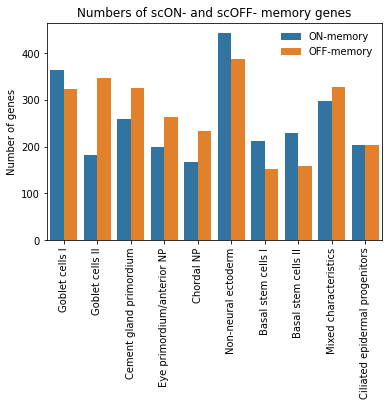

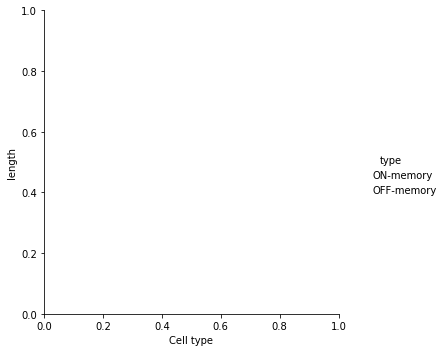

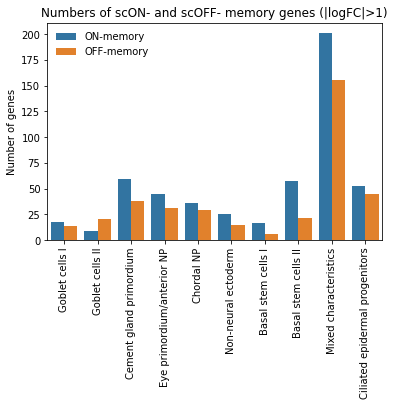

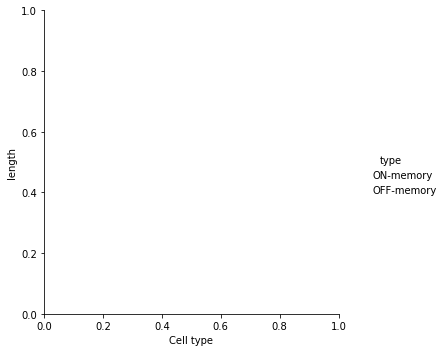

(None, None)

In [24]:
import seaborn as sns

fig, ax = plt.subplots(1,1)
plt.xticks(rotation=90)
ax.set_title('Numbers of scON- and scOFF- memory genes')
sns.catplot(x = "Cell type",       # x variable name
            y = "length",       # y variable name
            hue = "type",  # group variable name
            data = ON_OFF_df,     # dataframe to plot
            kind = "bar",
           ax=ax)
ax.legend(loc=0,frameon=False)
ax.set_ylabel('Number of genes')
ax.set_xlabel('')
plt.show(),plt.close()


fig, ax = plt.subplots(1,1)
plt.xticks(rotation=90)
ax.set_title('Numbers of scON- and scOFF- memory genes (|logFC|>1)')
sns.catplot(x = "Cell type",       # x variable name
            y = "length",       # y variable name
            hue = "type",  # group variable name
            data = ON_OFF_logFC_1_df,     # dataframe to plot
            kind = "bar",
           ax=ax)
ax.legend(loc=0,frameon=False)
ax.set_ylabel('Number of genes')
ax.set_xlabel('')
plt.show(),plt.close()



In [25]:
# Organize the data for the upset plot (both for the full lists and for those with
# |logFC|>1)
ON_memory_total=set(sc_ON_memory[0]+sc_ON_memory[1]+sc_ON_memory[2]+sc_ON_memory[3]+sc_ON_memory[4]+sc_ON_memory[5]+sc_ON_memory[6]+sc_ON_memory[7]+sc_ON_memory[8]+sc_ON_memory[9])
OFF_memory_total=set(sc_OFF_memory[0]+sc_OFF_memory[1]+sc_OFF_memory[2]+sc_OFF_memory[3]+sc_OFF_memory[4]+sc_OFF_memory[5]+sc_OFF_memory[6]+sc_OFF_memory[7]+sc_OFF_memory[8]+sc_OFF_memory[9])

ON_memory_total_logFC_1=set(sc_ON_memory_logFC_1[0]+sc_ON_memory_logFC_1[1]+sc_ON_memory_logFC_1[2]+sc_ON_memory_logFC_1[3]+sc_ON_memory_logFC_1[4]+sc_ON_memory_logFC_1[5]+sc_ON_memory_logFC_1[6]+sc_ON_memory_logFC_1[7]+sc_ON_memory_logFC_1[8]+sc_ON_memory_logFC_1[9])
OFF_memory_total_logFC_1=set(sc_OFF_memory_logFC_1[0]+sc_OFF_memory_logFC_1[1]+sc_OFF_memory_logFC_1[2]+sc_OFF_memory_logFC_1[3]+sc_OFF_memory_logFC_1[4]+sc_OFF_memory_logFC_1[5]+sc_OFF_memory_logFC_1[6]+sc_OFF_memory_logFC_1[7]+sc_OFF_memory_logFC_1[8]+sc_OFF_memory_logFC_1[9])

# Check if there is intersection between ON- and OFF- memory genes
print(ON_memory_total & OFF_memory_total)
print(ON_memory_total_logFC_1 & OFF_memory_total_logFC_1)

ON_OFF_total=list(ON_memory_total) + list(OFF_memory_total)
ON_OFF_total_logFC_1=list(ON_memory_total_logFC_1) + list(OFF_memory_total_logFC_1)

ON_OFF_count_df=pd.DataFrame(data={'Goblet cells I': [0]*len(ON_OFF_total),
                                   'Goblet cells II': [0]*len(ON_OFF_total),
                                   'Cement gland primordium': [0]*len(ON_OFF_total),
                                   'Eye primordium/anterior NP': [0]*len(ON_OFF_total),
                                   'Chordal NP': [0]*len(ON_OFF_total),
                                   'Non-neural ectoderm': [0]*len(ON_OFF_total),
                                   'Basal stem cells I': [0]*len(ON_OFF_total),
                                   'Basal stem cells II': [0]*len(ON_OFF_total),
                                   'Mixed characteristics': [0]*len(ON_OFF_total),
                                   'Ciliated epidermal progenitors': [0]*len(ON_OFF_total),
                                   'type': ['ON-memory']*len(ON_memory_total)+['OFF-memory']*len(OFF_memory_total),
                                   'Genes': ON_OFF_total}
                                   )

ON_OFF_count_df_logFC_1=pd.DataFrame(data={'Goblet cells I': [0]*len(ON_OFF_total_logFC_1),
                                   'Goblet cells II': [0]*len(ON_OFF_total_logFC_1),
                                   'Cement gland primordium': [0]*len(ON_OFF_total_logFC_1),
                                   'Eye primordium/anterior NP': [0]*len(ON_OFF_total_logFC_1),
                                   'Chordal NP': [0]*len(ON_OFF_total_logFC_1),
                                   'Non-neural ectoderm': [0]*len(ON_OFF_total_logFC_1),
                                   'Basal stem cells I': [0]*len(ON_OFF_total_logFC_1),
                                   'Basal stem cells II': [0]*len(ON_OFF_total_logFC_1),
                                   'Mixed characteristics': [0]*len(ON_OFF_total_logFC_1),
                                   'Ciliated epidermal progenitors': [0]*len(ON_OFF_total_logFC_1),
                                   'type': ['ON-memory']*len(ON_memory_total_logFC_1)+['OFF-memory']*len(OFF_memory_total_logFC_1),
                                   'Genes': ON_OFF_total_logFC_1}
                                   )

# Fill the dataframes
for i in range(len(ON_OFF_count_df)):
    if ON_OFF_count_df['type'].iloc[i]=='ON-memory':
        for j in range(len(sc_ON_memory_ordered)):
            if ON_OFF_count_df['Genes'].iloc[i] in sc_ON_memory_ordered[j]:
                ON_OFF_count_df[CT_names_ordered[j]].iloc[i]=1
    else:
        for j in range(len(sc_OFF_memory_ordered)):
            if ON_OFF_count_df['Genes'].iloc[i] in sc_OFF_memory_ordered[j]:
                ON_OFF_count_df[CT_names_ordered[j]].iloc[i]=1
                
for i in range(len(ON_OFF_count_df_logFC_1)):
    if ON_OFF_count_df_logFC_1['type'].iloc[i]=='ON-memory':
        for j in range(len(sc_ON_memory_logFC_1_ordered)):
            if ON_OFF_count_df_logFC_1['Genes'].iloc[i] in sc_ON_memory_logFC_1_ordered[j]:
                ON_OFF_count_df_logFC_1[CT_names_ordered[j]].iloc[i]=1
    else:
        for j in range(len(sc_OFF_memory_logFC_1_ordered)):
            if ON_OFF_count_df_logFC_1['Genes'].iloc[i] in sc_OFF_memory_logFC_1_ordered[j]:
                ON_OFF_count_df_logFC_1[CT_names_ordered[j]].iloc[i]=1

set()
set()


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


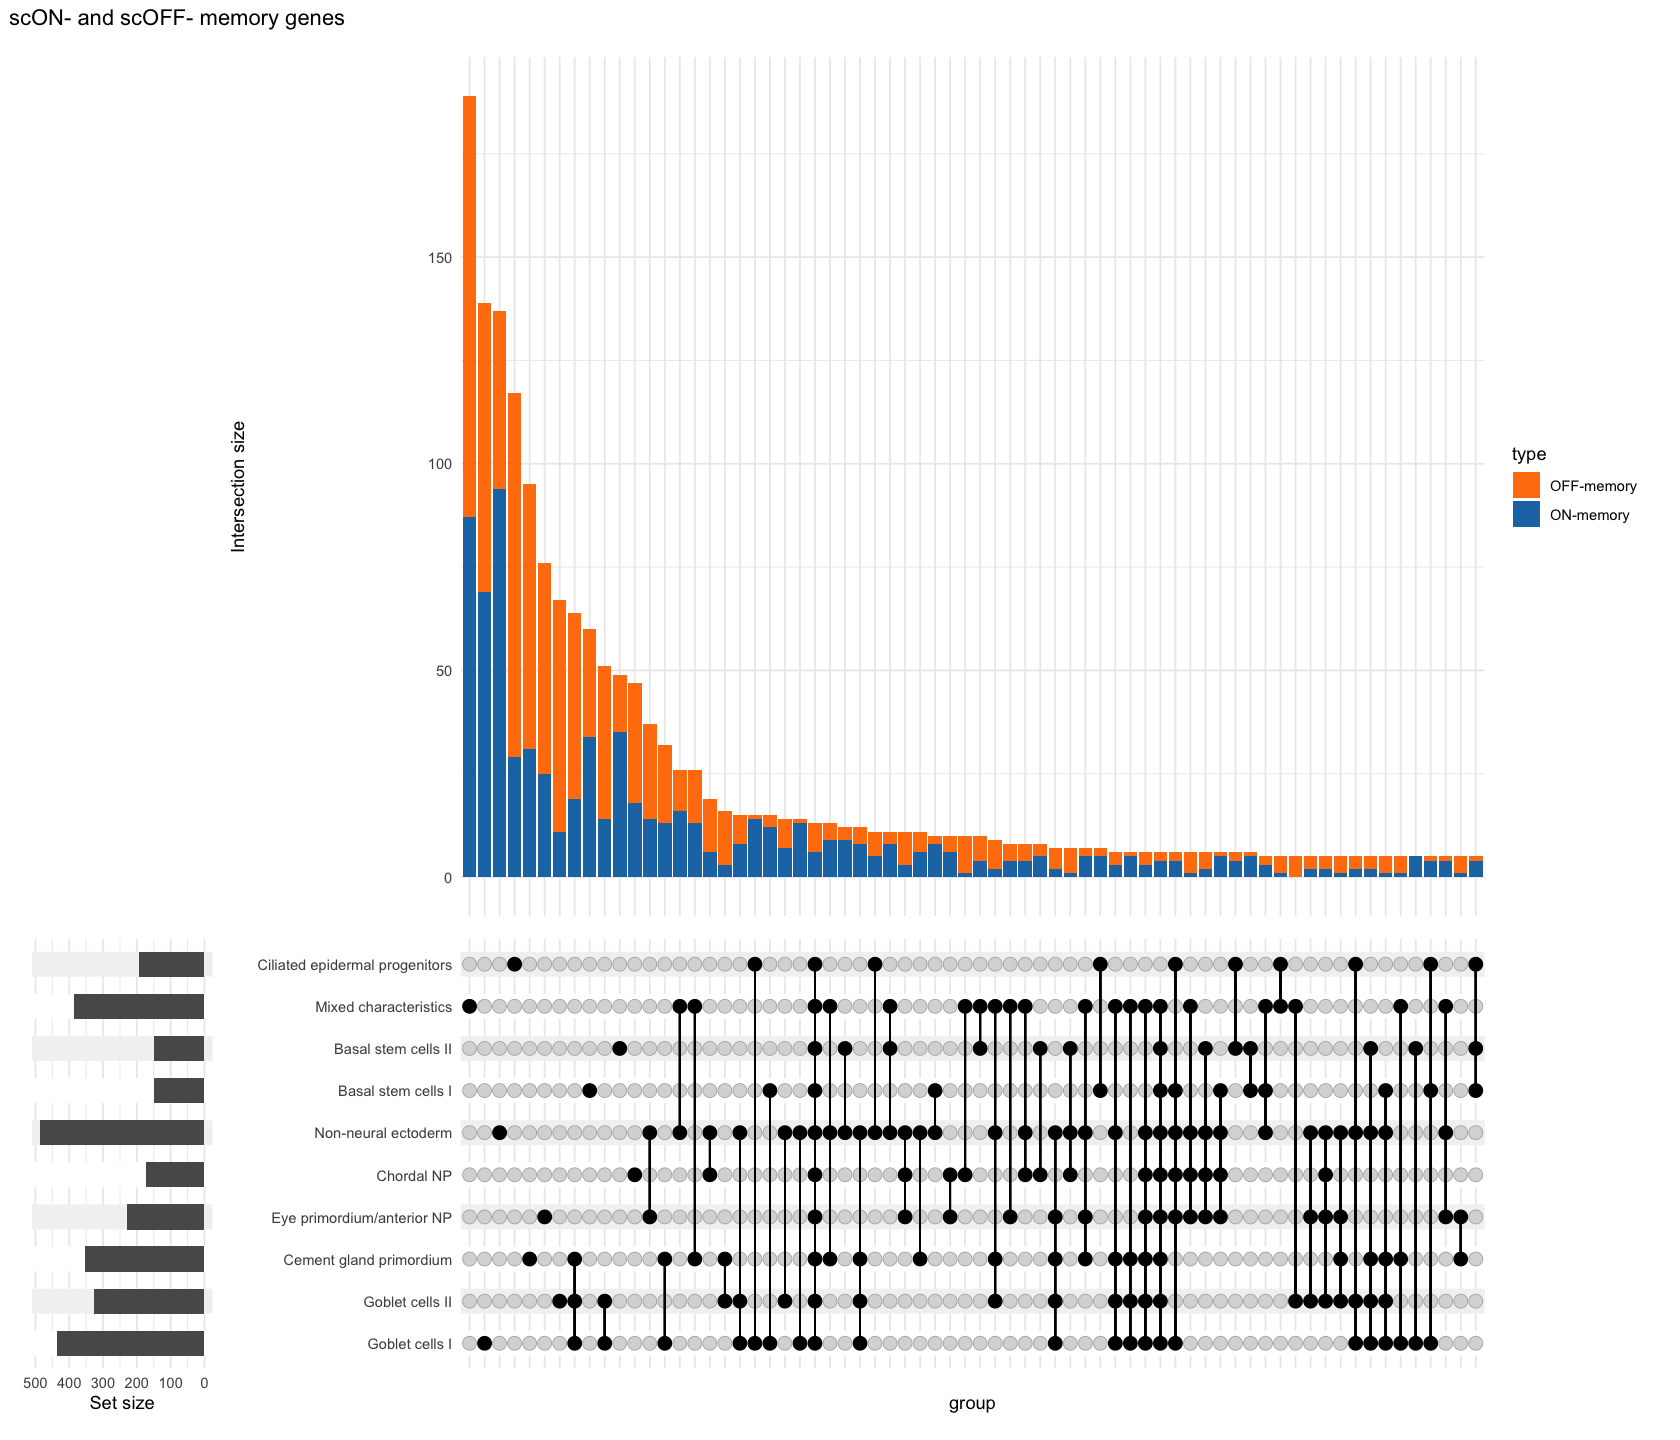

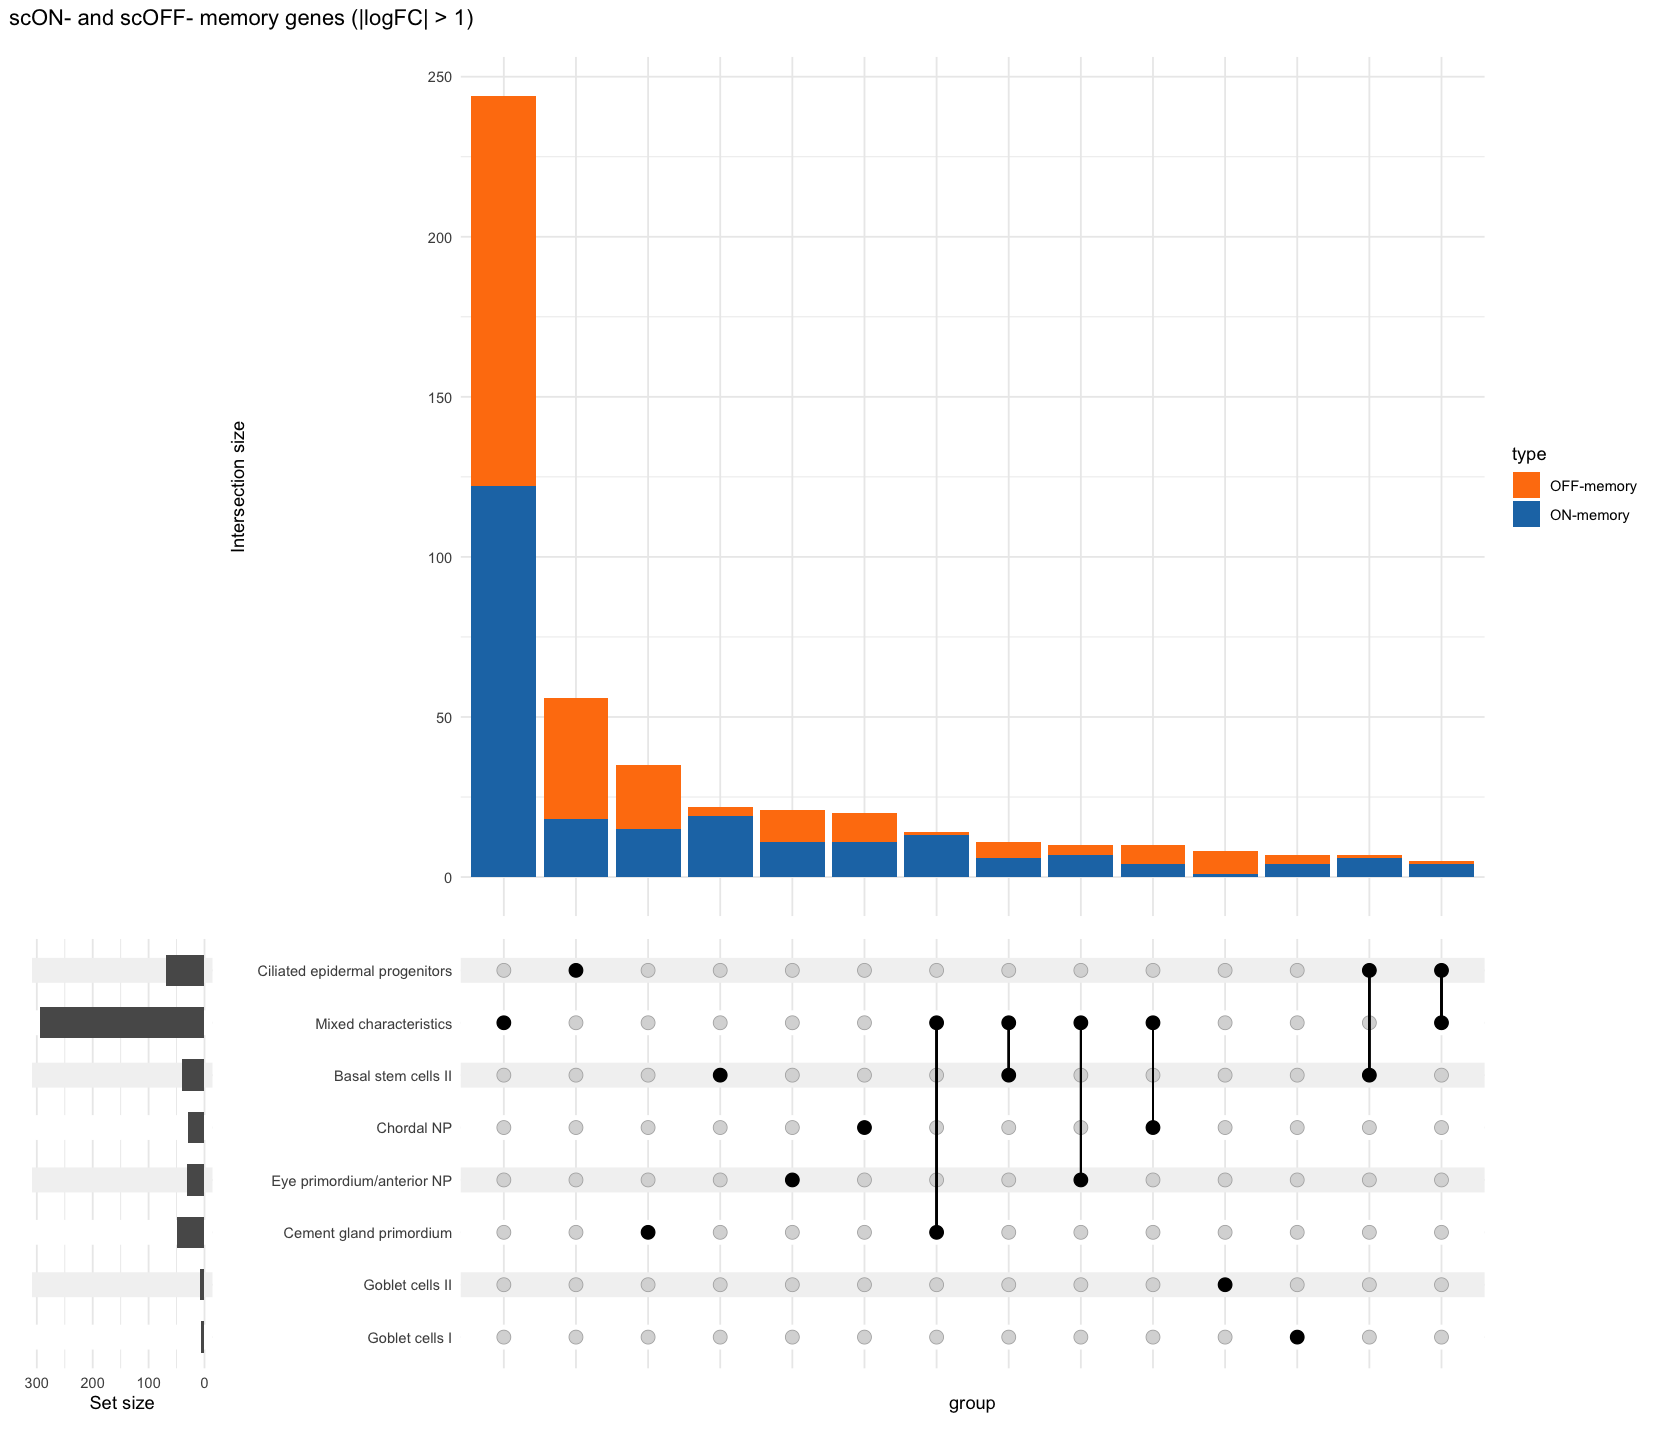

In [26]:
%get ON_OFF_count_df
%get ON_OFF_count_df_logFC_1

library(ComplexUpset)
celltypes = colnames(ON_OFF_count_df)[1:10]

# for simplicity of examples, only use the complete data points
# ON_OFF_count_df[ON_OFF_count_df$type == '', 'type'] = NA
# ON_OFF_count_df = na.omit(ON_OFF_count_df)

library(repr)
options(repr.plot.width=14, repr.plot.height=12)

upset(
    ON_OFF_count_df,
    celltypes,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=type))+ scale_fill_manual(values=c('OFF-memory'='#FF7F0E',
                                                            'ON-memory'='#1F77B4'))
        
    ),
    width_ratio=0.15,
    min_size=5,
    sort_sets=FALSE,
    wrap=TRUE
) + ggtitle('scON- and scOFF- memory genes')


upset(
    ON_OFF_count_df_logFC_1,
    celltypes,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=type))+ scale_fill_manual(values=c('OFF-memory'='#FF7F0E',
                                                            'ON-memory'='#1F77B4'))
        
    ),
    width_ratio=0.15,
    min_size=5,
    sort_sets=FALSE,
    wrap=TRUE
) + ggtitle('scON- and scOFF- memory genes (|logFC| > 1)')
#1f77b4
#ff7f0e
# 

## GO-term enrichment analysis for the newly defined ON- and OFF-memory genes

Note: to study the identity of the different sets of scON- and scOFF- memory genes, we could:

1) Select genes belonging to specific GO terms (e.g., endoderm development) and check their presence in the sets of memory genes

2) Check the intersection between the sets of memory genes and the cell type markers from the Tropicalis atlas (data S1 from Briggs), after Tropicalis-Laevis conversion of gene names

In [28]:
require(topGO)

folder <- "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Gene_lists/"

mapping.gene.GO <- read.table(paste(folder,"GeneGoTerms.txt",sep=""),sep="\t")
colnames(mapping.gene.GO)[2:4] <- c("Xenbase_gene_ID","gene_symbol","GO_Ids")

# Select only the gene name and GO terms columns in the mapping genes -> GO terms
my.map.gene.GO <- mapping.gene.GO[,c("gene_symbol","GO_Ids")]

# Format it as a named character vector
gene2GO.Xen <- as.character(my.map.gene.GO$GO_Ids)
names(gene2GO.Xen) <- my.map.gene.GO$gene_symbol

In [29]:
selFun <- function(gList){
    gList<0.05
}

topGO.XeLaev <- function(geneList,gene2GO.Xen,description.string){
    GOdata <- new("topGOdata",
               description = description.string,
               ontology = "BP",
               allGenes = geneList,
               geneSel = selFun,
               annot = annFUN.gene2GO,
               nodeSize = 5,
               gene2GO = gene2GO.Xen)
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultKS <- runTest(GOdata, algorithm = "classic", statistic = "ks")
    resultKS.elim <- runTest(GOdata, algorithm = "elim", statistic = "ks")

    minsigNodes <- min(c(resultFisher@geneData[4],resultKS@geneData[4],resultKS.elim@geneData[4]))
    
    if(minsigNodes < 2){
        print(c("0-1",description.string))
        allRes <- "None"
    }else if(minsigNodes>1 & minsigNodes < 5){
        print(c("2-4",description.string))
        my.top.Nodes <- minsigNodes
        allRes <- GenTable(GOdata, classicFisher = resultFisher,
                    classicKS = resultKS, elimKS = resultKS.elim,
                    orderBy = "elimKS", ranksOf = "classicFisher", topNodes = my.top.Nodes)
    }else{
        print(c("5-",description.string))
        my.top.Nodes <- 5
        allRes <- GenTable(GOdata, classicFisher = resultFisher,
                    classicKS = resultKS, elimKS = resultKS.elim,
                    orderBy = "elimKS", ranksOf = "classicFisher", topNodes = my.top.Nodes)
    }
#     print(resultKS)
#     print('-----------------------------')
#     print(resultKS.elim)
    
    allRes
}

In [30]:
bulk_data_ON_names = list(bulk_data_ON.index)
bulk_data_OFF_names = list(bulk_data_OFF.index)

In [152]:
%get bulk_data_ON_names
%get bulk_data_OFF_names

# Loop over the clusters, create an empty list of objects
results.folder <- "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res"

results.GO.ON.memory <- vector("list", 10)
results.GO.OFF.memory <- vector("list", 10)

for(i in seq(1:10)){    
    res.cluster <- read.csv(paste(results.folder,(i-1),".csv",sep = ""),row.names=1,
                            stringsAsFactors = FALSE)
    
    # Consider only genes significantly DE between donor and IVF in bulk
    # Consider also the filter on RPKM donor for ON-memory genes
    ON.names <- intersect(rownames(res.cluster),bulk_data_ON_names)
    OFF.names <- intersect(rownames(res.cluster),bulk_data_OFF_names)
    
    res.cluster.ON <- res.cluster[ON.names,]
    res.cluster.OFF <- res.cluster[OFF.names,]
    
    # Split genes with positive and negative logFC
    padj.list.ON <- res.cluster.ON[res.cluster.ON$log2FoldChange>0,]$padj
    names(padj.list.ON) <- rownames(res.cluster.ON[res.cluster.ON$log2FoldChange>0,])
    padj.list.OFF <- res.cluster.OFF[res.cluster.OFF$log2FoldChange<0,]$padj
    names(padj.list.OFF) <- rownames(res.cluster.OFF[res.cluster.OFF$log2FoldChange<0,])
    
    print(c((i-1),"ON",length(padj.list.ON),sum(selFun(padj.list.ON))))
    results.GO.ON.memory[[i]] <- topGO.XeLaev(padj.list.ON,gene2GO.Xen,
                            paste("GO of scON-memory genes for cluster ",(i-1),sep=""))
    
    print(c((i-1),"OFF",length(padj.list.OFF),sum(selFun(padj.list.OFF))))
    results.GO.OFF.memory[[i]] <- topGO.XeLaev(padj.list.OFF,gene2GO.Xen,
                            paste("GO of scOFF-memory genes for cluster ",(i-1),sep=""))
}

[1] "0"    "ON"   "1570" "443" 



Building most specific GOs .....

	( 14 GO terms found. )


Build GO DAG topology ..........

	( 124 GO terms and 252 relations. )


Annotating nodes ...............

	( 20 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 5:	1 nodes to be scored	(0 eliminated genes)


	 Level 4:	2 nodes to be scored	(0 eliminated genes)


	 Level 3:	5 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "5-"                                   
[2] "GO of scON-memory genes for cluster 0"
[1] "0"    "OFF"  "1075" "387" 



Building most specific GOs .....

	( 17 GO terms found. )


Build GO DAG topology ..........

	( 112 GO terms and 182 relations. )


Annotating nodes ...............

	( 21 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 19 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 19 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 19 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	1 nodes to be scored	(0 eliminated genes)


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	5 nodes to be scored	(0 eliminated genes)


	 Level 3:	4 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 0"
[1] "1"    "ON"   "1329" "364" 



Building most specific GOs .....

	( 16 GO terms found. )


Build GO DAG topology ..........

	( 142 GO terms and 291 relations. )


Annotating nodes ...............

	( 18 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 9 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 5:	1 nodes to be scored	(0 eliminated genes)


	 Level 4:	2 nodes to be scored	(0 eliminated genes)


	 Level 3:	5 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "5-"                                   
[2] "GO of scON-memory genes for cluster 1"
[1] "1"    "OFF"  "1407" "323" 



Building most specific GOs .....

	( 23 GO terms found. )


Build GO DAG topology ..........

	( 162 GO terms and 282 relations. )


Annotating nodes ...............

	( 31 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 24 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 29 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 29 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	1 nodes to be scored	(0 eliminated genes)


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	4 nodes to be scored	(0 eliminated genes)


	 Level 4:	9 nodes to be scored	(0 eliminated genes)


	 Level 3:	7 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 1"
[1] "2"   "ON"  "995" "181"



Building most specific GOs .....

	( 13 GO terms found. )


Build GO DAG topology ..........

	( 140 GO terms and 283 relations. )


Annotating nodes ...............

	( 15 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”

			 -- Classic Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 12 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 5:	1 nodes to be scored	(0 eliminated genes)


	 Level 4:	2 nodes to be scored	(0 eliminated genes)


	 Level 3:	5 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to

[1] "0-1"                                  
[2] "GO of scON-memory genes for cluster 2"
[1] "2"    "OFF"  "1530" "346" 



Building most specific GOs .....

	( 19 GO terms found. )


Build GO DAG topology ..........

	( 109 GO terms and 168 relations. )


Annotating nodes ...............

	( 26 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 25 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 25 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 25 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	2 nodes to be scored	(0 eliminated genes)


	 Level 8:	2 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	6 nodes to be scored	(0 eliminated genes)


	 Level 3:	6 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 2"
[1] "3"    "ON"   "1149" "211" 



Building most specific GOs .....

	( 12 GO terms found. )


Build GO DAG topology ..........

	( 105 GO terms and 226 relations. )


Annotating nodes ...............

	( 15 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 1 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 11 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 11 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 4:	2 nodes to be scored	(0 eliminated genes)


	 Level 3:	5 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "0-1"                                  
[2] "GO of scON-memory genes for cluster 3"
[1] "3"    "OFF"  "1355" "151" 



Building most specific GOs .....

	( 17 GO terms found. )


Build GO DAG topology ..........

	( 122 GO terms and 214 relations. )


Annotating nodes ...............

	( 21 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 18 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 21 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 21 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	1 nodes to be scored	(0 eliminated genes)


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(6 eliminated genes)


	 Level 6:	1 nodes to be scored	(6 eliminated genes)


	 Level 5:	2 nodes to be scored	(6 eliminated genes)


	 Level 4:	6 nodes to be scored	(6 eliminated genes)


	 Level 3:	5 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 3"
[1] "4"    "ON"   "1064" "258" 



Building most specific GOs .....

	( 11 GO terms found. )


Build GO DAG topology ..........

	( 109 GO terms and 197 relations. )


Annotating nodes ...............

	( 14 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 4:	1 nodes to be scored	(0 eliminated genes)


	 Level 3:	2 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "5-"                                   
[2] "GO of scON-memory genes for cluster 4"
[1] "4"    "OFF"  "1351" "326" 



Building most specific GOs .....

	( 18 GO terms found. )


Build GO DAG topology ..........

	( 151 GO terms and 291 relations. )


Annotating nodes ...............

	( 22 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 23 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 25 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 25 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	1 nodes to be scored	(0 eliminated genes)


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	7 nodes to be scored	(0 eliminated genes)


	 Level 3:	7 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 4"
[1] "5"    "ON"   "1290" "199" 



Building most specific GOs .....

	( 13 GO terms found. )


Build GO DAG topology ..........

	( 120 GO terms and 246 relations. )


Annotating nodes ...............

	( 14 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 4 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 4 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 4 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 3:	1 nodes to be scored	(0 eliminated genes)


	 Level 2:	2 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "2-4"                                  
[2] "GO of scON-memory genes for cluster 5"
[1] "5"    "OFF"  "1514" "264" 



Building most specific GOs .....

	( 20 GO terms found. )


Build GO DAG topology ..........

	( 149 GO terms and 294 relations. )


Annotating nodes ...............

	( 24 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 20 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 22 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 22 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	6 nodes to be scored	(0 eliminated genes)


	 Level 3:	6 nodes to be scored	(0 eliminated genes)


	 Level 2:	4 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 5"
[1] "6"    "ON"   "1103" "167" 



Building most specific GOs .....

	( 6 GO terms found. )


Build GO DAG topology ..........

	( 99 GO terms and 224 relations. )


Annotating nodes ...............

	( 6 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 2 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 2:	1 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "0-1"                                  
[2] "GO of scON-memory genes for cluster 6"
[1] "6"    "OFF"  "1768" "233" 



Building most specific GOs .....

	( 24 GO terms found. )


Build GO DAG topology ..........

	( 146 GO terms and 251 relations. )


Annotating nodes ...............

	( 32 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 28 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 28 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 28 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 12:	1 nodes to be scored	(0 eliminated genes)


	 Level 11:	1 nodes to be scored	(0 eliminated genes)


	 Level 10:	1 nodes to be scored	(0 eliminated genes)


	 Level 9:	2 nodes to be scored	(0 eliminated genes)


	 Level 8:	2 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be 

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 6"
[1] "7"    "ON"   "1310" "204" 



Building most specific GOs .....

	( 13 GO terms found. )


Build GO DAG topology ..........

	( 113 GO terms and 233 relations. )


Annotating nodes ...............

	( 17 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”

			 -- Classic Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 4:	1 nodes to be scored	(0 eliminated genes)


	 Level 3:	2 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "0-1"                                  
[2] "GO of scON-memory genes for cluster 7"
[1] "7"    "OFF"  "1467" "203" 



Building most specific GOs .....

	( 20 GO terms found. )


Build GO DAG topology ..........

	( 140 GO terms and 225 relations. )


Annotating nodes ...............

	( 24 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 18 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 23 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 23 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	2 nodes to be scored	(0 eliminated genes)


	 Level 8:	2 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	6 nodes to be scored	(0 eliminated genes)


	 Level 3:	5 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 7"
[1] "8"    "ON"   "1261" "228" 



Building most specific GOs .....

	( 11 GO terms found. )


Build GO DAG topology ..........

	( 109 GO terms and 237 relations. )


Annotating nodes ...............

	( 12 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”

			 -- Classic Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 7 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 4:	1 nodes to be scored	(0 eliminated genes)


	 Level 3:	2 nodes to be scored	(0 eliminated genes)


	 Level 2:	3 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "0-1"                                  
[2] "GO of scON-memory genes for cluster 8"
[1] "8"    "OFF"  "1388" "159" 



Building most specific GOs .....

	( 15 GO terms found. )


Build GO DAG topology ..........

	( 132 GO terms and 240 relations. )


Annotating nodes ...............

	( 18 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 18 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 18 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 18 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	1 nodes to be scored	(0 eliminated genes)


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	5 nodes to be scored	(0 eliminated genes)


	 Level 3:	4 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 8"
[1] "9"    "ON"   "1186" "298" 



Building most specific GOs .....

	( 11 GO terms found. )


Build GO DAG topology ..........

	( 112 GO terms and 205 relations. )


Annotating nodes ...............

	( 15 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 5 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 5 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 5 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 4:	1 nodes to be scored	(0 eliminated genes)


	 Level 3:	1 nodes to be scored	(0 eliminated genes)


	 Level 2:	2 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be scored	(0 eliminated genes)



[1] "5-"                                   
[2] "GO of scON-memory genes for cluster 9"
[1] "9"    "OFF"  "1213" "327" 



Building most specific GOs .....

	( 16 GO terms found. )


Build GO DAG topology ..........

	( 130 GO terms and 263 relations. )


Annotating nodes ...............

	( 19 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 19 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 22 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 22 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 8:	1 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	2 nodes to be scored	(0 eliminated genes)


	 Level 4:	6 nodes to be scored	(0 eliminated genes)


	 Level 3:	6 nodes to be scored	(0 eliminated genes)


	 Level 2:	4 nodes to be sco

[1] "5-"                                    
[2] "GO of scOFF-memory genes for cluster 9"


In [153]:
results.GO.ON.memory

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0008152,metabolic process,8,2,1.2,6,0.34,0.13,0.13
2,GO:0044237,cellular metabolic process,8,2,1.2,7,0.34,0.13,0.13
3,GO:0006807,nitrogen compound metabolic process,6,2,0.9,1,0.20,0.34,0.34
4,GO:0043170,macromolecule metabolic process,6,2,0.9,2,0.20,0.34,0.34
5,GO:0044238,primary metabolic process,6,2,0.9,3,0.20,0.34,0.34
,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0009987,cellular process,14,2,3.11,8,0.98,0.68,0.68
2,GO:0050789,regulation of biological process,7,0,1.56,9,1.00,0.87,0.87


In [154]:
results.GO.OFF.memory

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0008380,RNA splicing,5,4,2.62,2,0.185,0.031,0.031
2,GO:0006396,RNA processing,6,5,3.14,1,0.094,0.087,0.087
3,GO:0009987,cellular process,17,10,8.90,8,0.256,0.180,0.180
4,GO:0006139,nucleobase-containing compound metabolic...,7,5,3.67,3,0.221,0.180,0.180
5,GO:0010467,gene expression,7,5,3.67,4,0.221,0.180,0.180
,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0044085,cellular component biogenesis,7,2,0.68,1,0.12,0.38,0.38
2,GO:0071840,cellular component organization or bioge...,7,2,0.68,2,0.12,0.38,0.38


## GO-term enrichment analysis for the union of ON- and OFF-memory genes

In order to get more genes for the GO enrichment analysis, we take the union of all the ON- or all the OFF-memory genes.

- Union of all the results of the DE between IVF and NT

- Remove duplicates, keeping the genes with smallest p-value (we want to consider genes as significant if they were significant in at least one cluster)

- Run GO-term enrichment analysis with topGO

In [41]:
%get bulk_data_ON_names
%get bulk_data_OFF_names

# Loop over the clusters, create an empty list of objects
results.folder <- "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/res"

res.cluster <- read.csv(paste(results.folder,"0",".csv",sep = ""),row.names=1,
                            stringsAsFactors = FALSE)
    
# Consider only genes significantly DE between donor and IVF in bulk
# Consider also the filter on RPKM donor for ON-memory genes
ON.names <- intersect(rownames(res.cluster),bulk_data_ON_names)
OFF.names <- intersect(rownames(res.cluster),bulk_data_OFF_names)
    
res.cluster.ON <- res.cluster[ON.names,]
res.cluster.OFF <- res.cluster[OFF.names,]
    
res.cluster.ON.tot <- res.cluster.ON[res.cluster.ON$log2FoldChange>0,]
res.cluster.OFF.tot <- res.cluster.OFF[res.cluster.OFF$log2FoldChange<0,]

res.cluster.ON.tot$names <- rownames(res.cluster.ON.tot)
res.cluster.OFF.tot$names <- rownames(res.cluster.OFF.tot)

for(i in seq(2:10)){    
    res.cluster <- read.csv(paste(results.folder,(i-1),".csv",sep = ""),row.names=1,
                            stringsAsFactors = FALSE)
    
    # Consider only genes significantly DE between donor and IVF in bulk
    # Consider also the filter on RPKM donor for ON-memory genes
    ON.names <- intersect(rownames(res.cluster),bulk_data_ON_names)
    OFF.names <- intersect(rownames(res.cluster),bulk_data_OFF_names)
    
    res.cluster.ON <- res.cluster[ON.names,]
    res.cluster.OFF <- res.cluster[OFF.names,]
    
    res.cluster.ON <- res.cluster.ON[res.cluster.ON$log2FoldChange>0,]
    res.cluster.OFF <- res.cluster.OFF[res.cluster.OFF$log2FoldChange<0,]
    
    res.cluster.ON$names <- rownames(res.cluster.ON)
    res.cluster.OFF$names <- rownames(res.cluster.OFF)
    
    # Concatenate to the existing dataframe
    res.cluster.ON.tot <- rbind(res.cluster.ON.tot, res.cluster.ON)
    res.cluster.OFF.tot <- rbind(res.cluster.OFF.tot, res.cluster.OFF)
    
    }

res.cluster.ON.tot <- res.cluster.ON.tot[order(res.cluster.ON.tot[,'names'],
                                              res.cluster.ON.tot[,'padj']),]
res.cluster.ON.tot <- res.cluster.ON.tot[!duplicated(res.cluster.ON.tot$names),]

res.cluster.OFF.tot <- res.cluster.OFF.tot[order(res.cluster.OFF.tot[,'names'],
                                              res.cluster.OFF.tot[,'padj']),]
res.cluster.OFF.tot <- res.cluster.OFF.tot[!duplicated(res.cluster.OFF.tot$names),]

rownames(res.cluster.ON.tot) <- res.cluster.ON.tot$names
rownames(res.cluster.OFF.tot) <- res.cluster.OFF.tot$names

padj.list.tot.ON <- res.cluster.ON.tot$padj
padj.list.tot.OFF <- res.cluster.OFF.tot$padj
names(padj.list.tot.ON) <- rownames(res.cluster.ON.tot)
names(padj.list.tot.OFF) <- rownames(res.cluster.OFF.tot)

print(c("All ON",length(padj.list.tot.ON),sum(selFun(padj.list.tot.ON))))
results.GO.ON.memory.tot <- topGO.XeLaev(padj.list.tot.ON,gene2GO.Xen,
                                          "GO of the union of scON-memory genes")

print(c("All OFF",length(padj.list.tot.OFF),sum(selFun(padj.list.tot.OFF))))
results.GO.OFF.memory.tot <- topGO.XeLaev(padj.list.tot.OFF,gene2GO.Xen,
                                          "GO of the union of scOFF-memory genes")
    

[1] "All ON" "2707"   "917"   



Building most specific GOs .....

	( 24 GO terms found. )


Build GO DAG topology ..........

	( 178 GO terms and 347 relations. )


Annotating nodes ...............

	( 36 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 23 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 27 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 27 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be scored	(0 eliminated genes)


	 Level 5:	4 nodes to be scored	(0 eliminated genes)


	 Level 4:	6 nodes to be scored	(0 eliminated genes)


	 Level 3:	8 nodes to be scored	(0 eliminated genes)


	 Level 2:	6 nodes to be scored	(0 eliminated genes)


	 Level 1:	1 nodes to be sco

[1] "5-"                                  
[2] "GO of the union of scON-memory genes"
[1] "All OFF" "3926"    "1035"   



Building most specific GOs .....

	( 42 GO terms found. )


Build GO DAG topology ..........

	( 264 GO terms and 477 relations. )


Annotating nodes ...............

	( 61 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 38 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 42 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 42 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 12:	1 nodes to be scored	(0 eliminated genes)


	 Level 11:	1 nodes to be scored	(0 eliminated genes)


	 Level 10:	1 nodes to be scored	(0 eliminated genes)


	 Level 9:	2 nodes to be scored	(0 eliminated genes)


	 Level 8:	2 nodes to be scored	(0 eliminated genes)


	 Level 7:	1 nodes to be scored	(0 eliminated genes)


	 Level 6:	1 nodes to be 

[1] "5-"                                   
[2] "GO of the union of scOFF-memory genes"


In [48]:
length(intersect(names(gene2GO.Xen),names(padj.list.tot.ON)))

[1] 1842

In [42]:
results.GO.ON.memory.tot

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0008152,metabolic process,10,3,2.50,14,0.49,0.022,0.022
2,GO:0044237,cellular metabolic process,10,3,2.50,15,0.49,0.022,0.022
3,GO:0006139,nucleobase-containing compound metabolic...,5,2,1.25,6,0.37,0.075,0.075
4,GO:0006725,cellular aromatic compound metabolic pro...,5,2,1.25,7,0.37,0.075,0.075
5,GO:0010467,gene expression,5,2,1.25,8,0.37,0.075,0.075


In [43]:
results.GO.OFF.memory.tot

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0008380,RNA splicing,9,5,2.51,1,0.059,0.022,0.022
2,GO:0006396,RNA processing,14,6,3.90,2,0.139,0.156,0.156
3,GO:0000375,"RNA splicing, via transesterification re...",7,3,1.95,6,0.299,0.247,0.247
4,GO:0000377,"RNA splicing, via transesterification re...",7,3,1.95,7,0.299,0.247,0.247
5,GO:0000398,"mRNA splicing, via spliceosome",7,3,1.95,8,0.299,0.247,0.247


## Enrichment for bulk ON- and OFF- memory genes in each cell type

We look at the enrichment for:

1. Bulk ON- and OFF- memory genes in the sets of ON- and OFF- memory genes defined from the single-cell RNA-seq data

2. Same as 1. but considering bulk ON- and OFF- memory genes with |logFC|>1.5 (3FC genes)

3. Same as 1. but only for genes with |logFC|>1 in scRNA-seq

In [16]:
# Select the ON- and OFF- memory genes from the bulk RNA-seq data
filtered_bulk_data_ON=bulk_data_ON[bulk_data_ON['FDR=NT_vs_IVF'] < 0.05]
filtered_bulk_data_ON=filtered_bulk_data_ON[filtered_bulk_data_ON['logFC=NT_vs_IVF'] > 0]

# Define the 3FC ON-memory genes from bulk
filtered_bulk_data_ON_3FC=filtered_bulk_data_ON[filtered_bulk_data_ON['logFC=NT_vs_IVF'] > 1.5]

filtered_bulk_data_OFF=bulk_data_OFF[bulk_data_OFF['FDR=NT_vs_IVF'] < 0.05]
filtered_bulk_data_OFF=filtered_bulk_data_OFF[filtered_bulk_data_OFF['logFC=NT_vs_IVF'] < 0]

# Define the 3FC ON-memory genes from bulk
filtered_bulk_data_OFF_3FC=filtered_bulk_data_OFF[filtered_bulk_data_OFF['logFC=NT_vs_IVF'] < -1.5]

In [17]:
import scipy.stats as stats

# For each cell type, perform Fisher's exact
# test looking for enrichment for bulk ON- or OFF- memory genes in the list
# of single-cell ON- and OFF- memory genes
# index is the cluster index
# type_lab can be ON or OFF
# FC_lab indicates whether all the significant genes should be considered or if a filter on the 
# logFC should be applied. Default is 'all', the other option is 'filter'
# filtered bulk are the bulk data only for ON- or OFF- memory genes
# bulk are the bulk data not filtered on the basis of the DE between IVF and NT 
def FisherExact(index, type_lab, FC_lab,filtered_bulk,bulk):
    DE_results=pd.read_csv(DE_IVF_NT_folder+'res'+str(index)+'.csv',index_col=0)
    
    # Consider significant genes
    DE_results_sign=DE_results[DE_results['padj'] < 0.05]
    
    if type_lab=='ON':
        if FC_lab=='filter':
            DE_results_sign=DE_results_sign[DE_results_sign['log2FoldChange']>1]
        else:
            DE_results_sign=DE_results_sign[DE_results_sign['log2FoldChange']>0]
    else:
        if FC_lab=='filter':
            DE_results_sign=DE_results_sign[DE_results_sign['log2FoldChange']< -1]
        else:
            DE_results_sign=DE_results_sign[DE_results_sign['log2FoldChange']< 0]
            
    tested_genes=list(DE_results.index)
    bulk_in_tested=list(set(filtered_bulk.index) & set(DE_results.index))
    sc_memory=list(set(list(DE_results_sign.index)) & set(list(bulk.index)))
    intersection_bulk_sc=list(set(bulk_in_tested) & set(sc_memory))
    
    a11=len(tested_genes)-len(bulk_in_tested)
    a12=len(bulk_in_tested)
    a21=len(sc_memory)-len(intersection_bulk_sc)
    a22=len(intersection_bulk_sc)
    
    oddsratio, pvalue = stats.fisher_exact([[a11, a12], [a21, a22]])
    
    print(index,len(tested_genes),len(bulk_in_tested),
         len(sc_memory),len(intersection_bulk_sc),
          100*(len(intersection_bulk_sc)/len(sc_memory)),pvalue)
    
    return [len(tested_genes),len(bulk_in_tested),len(sc_memory),len(intersection_bulk_sc),pvalue];

In [18]:
import scipy.stats as stats

total_fisher_res_ON=[]

for i in range(10):
    fisher_res_ON=FisherExact(i,'ON','all',filtered_bulk_data_ON,bulk_data_ON)
    total_fisher_res_ON.append(fisher_res_ON)

print('\n')
print('------------------------------------------')
print('\n')
    
total_fisher_res_ON_logFC_1=[]

for i in range(10):
    fisher_res_ON_logFC_1=FisherExact(i,'ON','filter',filtered_bulk_data_ON,bulk_data_ON)
    total_fisher_res_ON_logFC_1.append(fisher_res_ON_logFC_1)

print('\n')
print('------------------------------------------')
print('\n')    

total_fisher_res_ON_3FC=[]

for i in range(10):
    fisher_res_ON_3FC=FisherExact(i,'ON','all',filtered_bulk_data_ON_3FC,bulk_data_ON)
    total_fisher_res_ON_3FC.append(fisher_res_ON_3FC)

print('\n')
print('------------------------------------------')
print('\n')    

total_fisher_res_OFF=[]

for i in range(10):
    fisher_res_OFF=FisherExact(i,'OFF','all',filtered_bulk_data_OFF,bulk_data_OFF)
    total_fisher_res_OFF.append(fisher_res_OFF)
    
print('\n')
print('------------------------------------------')
print('\n')    

total_fisher_res_OFF_logFC_1=[]

for i in range(10):
    fisher_res_OFF_logFC_1=FisherExact(i,'OFF','filter',filtered_bulk_data_OFF,bulk_data_OFF)
    total_fisher_res_OFF_logFC_1.append(fisher_res_OFF_logFC_1)
    
total_fisher_res_OFF_3FC=[]

for i in range(10):
    fisher_res_OFF_3FC=FisherExact(i,'OFF','all',filtered_bulk_data_OFF_3FC,bulk_data_OFF)
    total_fisher_res_OFF_3FC.append(fisher_res_OFF_3FC)

print('\n')
print('------------------------------------------')
print('\n')    

0 10210 474 443 134 30.248306997742663 1.4078101075278353e-63
1 11146 550 364 65 17.857142857142858 2.5617218088267003e-18
2 10689 497 181 36 19.88950276243094 3.5992512907339683e-13
3 8733 373 211 25 11.848341232227488 6.880841005672753e-06
4 10417 498 258 59 22.868217054263564 8.342432288326125e-23
5 9231 384 199 37 18.592964824120603 7.197086790694977e-14
6 8090 314 167 28 16.766467065868262 1.74458812923659e-10
7 8752 365 204 41 20.098039215686274 2.7143783224892345e-16
8 9278 398 228 43 18.859649122807017 1.4250206171791012e-15
9 10003 485 298 98 32.88590604026846 4.505512603616295e-50


------------------------------------------


0 10210 474 25 10 40.0 8.776326410406794e-08
1 11146 550 18 5 27.77777777777778 0.001488413883969065
2 10689 497 9 2 22.22222222222222 0.06288722172474769
3 8733 373 17 3 17.647058823529413 0.03419283347372929
4 10417 498 59 20 33.89830508474576 2.4526751852501896e-12
5 9231 384 45 13 28.888888888888886 2.7849868650474818e-08
6 8090 314 36 14 38.8888888

In [20]:
import numpy as np

total_fisher_res_ON=np.array([total_fisher_res_ON[i] for i in order])
total_fisher_res_ON_logFC_1=np.array([total_fisher_res_ON_logFC_1[i] for i in order])
total_fisher_res_ON_3FC=np.array([total_fisher_res_ON_3FC[i] for i in order])
total_fisher_res_OFF=np.array([total_fisher_res_OFF[i] for i in order])
total_fisher_res_OFF_logFC_1=np.array([total_fisher_res_OFF_logFC_1[i] for i in order])
total_fisher_res_OFF_3FC=np.array([total_fisher_res_OFF_3FC[i] for i in order])

In [21]:
# total_fisher_res_df=pd.DataFrame(data={'number': list(total_fisher_res_ON[:,1])+list(total_fisher_res_ON[:,3])+ list(total_fisher_res_OFF[:,1])+list(total_fisher_res_OFF[:,3])
#                                        , 'type': ['ON']*2*len(total_fisher_res_ON)+['OFF']*2*len(total_fisher_res_OFF)
#                                        , 'bulk_memory': ['tested']*len(total_fisher_res_ON)+['signif']*len(total_fisher_res_ON)+['tested']*len(total_fisher_res_OFF)+['signif']*len(total_fisher_res_OFF)
#                                        , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

# total_fisher_res_df_logFC_1=pd.DataFrame(data={'number': list(total_fisher_res_ON_logFC_1[:,1])+list(total_fisher_res_ON_logFC_1[:,3])+ list(total_fisher_res_OFF_logFC_1[:,1])+list(total_fisher_res_OFF_logFC_1[:,3])
#                                        , 'type': ['ON']*2*len(total_fisher_res_ON_logFC_1)+['OFF']*2*len(total_fisher_res_OFF_logFC_1)
#                                        , 'bulk_memory': ['tested']*len(total_fisher_res_ON_logFC_1)+['signif']*len(total_fisher_res_ON_logFC_1)+['tested']*len(total_fisher_res_OFF_logFC_1)+['signif']*len(total_fisher_res_OFF_logFC_1)
#                                        , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

# total_fisher_res_df_3FC=pd.DataFrame(data={'number': list(total_fisher_res_ON_3FC[:,1])+list(total_fisher_res_ON_3FC[:,3])+ list(total_fisher_res_OFF_3FC[:,1])+list(total_fisher_res_OFF_3FC[:,3])
#                                        , 'type': ['ON']*2*len(total_fisher_res_ON_3FC)+['OFF']*2*len(total_fisher_res_OFF_3FC)
#                                        , 'bulk_memory': ['tested']*len(total_fisher_res_ON_3FC)+['signif']*len(total_fisher_res_ON_3FC)+['tested']*len(total_fisher_res_OFF_3FC)+['signif']*len(total_fisher_res_OFF_3FC)
#                                        , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

In [22]:
total_fisher_res_df=pd.DataFrame(data={'number': list(100.0*(total_fisher_res_ON[:,1]/total_fisher_res_ON[:,0]))+list(100.0*(total_fisher_res_ON[:,3]/total_fisher_res_ON[:,2]))+ list(100.0*(total_fisher_res_OFF[:,1]/total_fisher_res_OFF[:,0]))+list(100.0*(total_fisher_res_OFF[:,3]/total_fisher_res_OFF[:,2]))
                                       , 'type': ['ON']*2*len(total_fisher_res_ON)+['OFF']*2*len(total_fisher_res_OFF)
                                       , 'bulk_memory': ['in_tested']*len(total_fisher_res_ON)+['in_signif']*len(total_fisher_res_ON)+['in_tested']*len(total_fisher_res_OFF)+['in_signif']*len(total_fisher_res_OFF)
                                       , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

total_fisher_res_df_logFC_1=pd.DataFrame(data={'number': list(100.0*(total_fisher_res_ON_logFC_1[:,1]/total_fisher_res_ON_logFC_1[:,0]))+list(100.0*(total_fisher_res_ON_logFC_1[:,3]/total_fisher_res_ON_logFC_1[:,2]))+ list(100.0*(total_fisher_res_OFF_logFC_1[:,1]/total_fisher_res_OFF_logFC_1[:,0]))+list(100.0*(total_fisher_res_OFF_logFC_1[:,3]/total_fisher_res_OFF_logFC_1[:,2]))
                                       , 'type': ['ON']*2*len(total_fisher_res_ON_logFC_1)+['OFF']*2*len(total_fisher_res_OFF_logFC_1)
                                       , 'bulk_memory': ['in_tested']*len(total_fisher_res_ON_logFC_1)+['in_signif']*len(total_fisher_res_ON_logFC_1)+['in_tested']*len(total_fisher_res_OFF_logFC_1)+['in_signif']*len(total_fisher_res_OFF_logFC_1)
                                       , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

total_fisher_res_df_3FC=pd.DataFrame(data={'number': list(100.0*(total_fisher_res_ON_3FC[:,1]/total_fisher_res_ON_3FC[:,0]))+list(100.0*(total_fisher_res_ON_3FC[:,3]/total_fisher_res_ON_3FC[:,2]))+ list(100.0*(total_fisher_res_OFF_3FC[:,1]/total_fisher_res_OFF_3FC[:,0]))+list(100.0*(total_fisher_res_OFF_3FC[:,3]/total_fisher_res_OFF_3FC[:,2]))
                                       , 'type': ['ON']*2*len(total_fisher_res_ON_3FC)+['OFF']*2*len(total_fisher_res_OFF_3FC)
                                       , 'bulk_memory': ['in_tested']*len(total_fisher_res_ON_3FC)+['in_signif']*len(total_fisher_res_ON_3FC)+['in_tested']*len(total_fisher_res_OFF_3FC)+['in_signif']*len(total_fisher_res_OFF_3FC)
                                       , 'Cell_type': CT_names_ordered+CT_names_ordered+CT_names_ordered+CT_names_ordered})

In [23]:
p_values_df=pd.DataFrame(data={'p_value': list( -np.log10(total_fisher_res_ON[:,4])) + list( -np.log10(total_fisher_res_OFF[:,4]))
                                , 'type': ['ON']*len(total_fisher_res_ON) + ['OFF']*len(total_fisher_res_OFF)
                                , 'Cell_type': CT_names_ordered+CT_names_ordered})

p_values_df_logFC_1=pd.DataFrame(data={'p_value': list( -np.log10(total_fisher_res_ON_logFC_1[:,4])) + list( -np.log10(total_fisher_res_OFF_logFC_1[:,4]))
                                , 'type': ['ON']*len(total_fisher_res_ON_logFC_1) + ['OFF']*len(total_fisher_res_OFF_logFC_1)
                                , 'Cell_type': CT_names_ordered+CT_names_ordered})

p_values_df_3FC=pd.DataFrame(data={'p_value': list( -np.log10(total_fisher_res_ON_3FC[:,4])) + list( -np.log10(total_fisher_res_OFF_3FC[:,4]))
                                , 'type': ['ON']*len(total_fisher_res_ON_3FC) + ['OFF']*len(total_fisher_res_OFF_3FC)
                                , 'Cell_type': CT_names_ordered+CT_names_ordered})

In [25]:
total_fisher_res_OFF_logFC_1

array([[1.11460000e+04, 8.70000000e+02, 1.40000000e+01, 7.00000000e+00,
        3.79408569e-05],
       [1.06890000e+04, 8.69000000e+02, 2.00000000e+01, 1.00000000e+01,
        1.13844167e-06],
       [1.04170000e+04, 8.70000000e+02, 3.80000000e+01, 1.50000000e+01,
        1.76318003e-07],
       [9.23100000e+03, 8.43000000e+02, 3.10000000e+01, 1.70000000e+01,
        1.84714989e-10],
       [8.09000000e+03, 8.08000000e+02, 2.90000000e+01, 1.70000000e+01,
        1.79314784e-10],
       [1.02100000e+04, 8.60000000e+02, 1.50000000e+01, 8.00000000e+00,
        9.79079733e-06],
       [8.73300000e+03, 8.17000000e+02, 6.00000000e+00, 2.00000000e+00,
        1.02063925e-01],
       [9.27800000e+03, 8.31000000e+02, 2.10000000e+01, 9.00000000e+00,
        4.15434506e-05],
       [1.00030000e+04, 8.44000000e+02, 1.55000000e+02, 7.20000000e+01,
        6.49604588e-35],
       [8.75200000e+03, 8.06000000e+02, 4.50000000e+01, 4.00000000e+00,
        1.00000000e+00]])

In [365]:
%get total_fisher_res_df
%get total_fisher_res_df_logFC_1
%get total_fisher_res_df_3FC
%get p_values_df
%get p_values_df_logFC_1
%get p_values_df_3FC
%get CT_names_ordered

total_fisher_res_df$bulk_memory <- factor(total_fisher_res_df$bulk_memory,
                                          levels = c('in_tested', 'in_signif'))
total_fisher_res_df_logFC_1$bulk_memory <- factor(total_fisher_res_df_logFC_1$bulk_memory,
                                                  levels = c('in_tested', 'in_signif'))
total_fisher_res_df_3FC$bulk_memory <- factor(total_fisher_res_df_3FC$bulk_memory,
                                              levels = c('in_tested', 'in_signif'))

total_fisher_res_df$type <- factor(total_fisher_res_df$type, levels = c('ON', 'OFF'))
total_fisher_res_df_logFC_1$type <- factor(total_fisher_res_df_logFC_1$type, levels = c('ON', 'OFF'))
total_fisher_res_df_3FC$type <- factor(total_fisher_res_df_3FC$type, levels = c('ON', 'OFF'))

p_values_df$type <- factor(p_values_df$type, levels = c('ON', 'OFF'))
p_values_df_logFC_1$type <- factor(p_values_df_logFC_1$type, levels = c('ON', 'OFF'))
p_values_df_3FC$type <- factor(p_values_df_3FC$type, levels = c('ON', 'OFF'))



total_fisher_res_df$Cell_type <- factor(total_fisher_res_df$Cell_type, levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))
total_fisher_res_df_logFC_1$Cell_type <- factor(total_fisher_res_df_logFC_1$Cell_type,
                                                levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))

total_fisher_res_df_3FC$Cell_type <- factor(total_fisher_res_df_3FC$Cell_type,
                                                levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))

p_values_df$Cell_type <- factor(p_values_df$Cell_type, levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))

p_values_df_3FC$Cell_type <- factor(p_values_df_3FC$Cell_type,
                                                levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))

p_values_df_logFC_1$Cell_type <- factor(p_values_df_logFC_1$Cell_type,
                                                levels = c('Goblet cells I',
 'Goblet cells II',
 'Cement gland primordium',
 'Eye primordium/anterior NP',
 'Chordal NP',
 'Non-neural ectoderm',
 'Basal stem cells I',
 'Basal stem cells II',
 'Mixed characteristics',
 'Ciliated epidermal progenitors'))

In [425]:
library(grid)
library(repr)
options(repr.plot.width=18, repr.plot.height=10)

# 1. Compare sc and bulk ON- and OFF- memory genes in each cell type
pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/enrichment_memory_bulk_sc.pdf",
    width=18,height=10)
dodge <- position_dodge(width = 0.9)
g1 <- ggplot(data = total_fisher_res_df, aes(x = interaction(type, Cell_type),
                                             y = number, fill = factor(bulk_memory))) +
  geom_bar(stat = "identity", position = dodge) +
#   geom_text(aes(label=number), position=dodge, vjust=-0.25) +
  coord_cartesian(ylim = c(0, 60)) +
   annotate("text", x = 1:20, y = - 4.5,
            label = rep(c("ON", "OFF"), 10),size=5) +#+
  annotate("text", c(1.5, 3.5, 5.4, 7.5, 9.5, 11.5, 13.5, 15.5,
                    17.5,19.5), y = - 7.5, label = c('Goblet\ncells I',
 'Goblet\ncells II',
 'Cement gland\nprimordium',
 'Eye primordium\n/anterior NP',
 'Chordal NP',
 'Non-neural\nectoderm',
 'Basal stem\ncells I',
 'Basal stem\ncells II',
 'Mixed\ncharacteristics',
 'Ciliated epidermal\nprogenitors'),size=5) +
  theme_classic(base_size=22) +
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
       axis.title.x = element_blank(),
       axis.text.x = element_blank())+
  labs(fill = "Bulk memory\ngenes",y="Percentage")+
  ggtitle("Enrichment for bulk memory genes in single-cell memory genes") 

# remove clipping of x axis labels
g2 <- ggplot_gtable(ggplot_build(g1))
g2$layout$clip[g2$layout$name == "panel"] <- "off"
grid.draw(g2)
dev.off()

pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/pvalues_memory_bulk_sc.pdf",
   width=18,height=10)
ggplot(p_values_df, aes(fill=type, y=p_value, x=Cell_type)) + 
    theme_classic(base_size = 26) +
    geom_bar(position="dodge", stat="identity")+
    geom_hline(yintercept= -log10(0.05), linetype="dashed", size=3, color = "red") +
    ylab("-log10(p-value)") + xlab("")+coord_flip()+
    scale_fill_manual(values=c('OFF'='#FF7F0E','ON'='#1F77B4'))
dev.off()

pdf 
  2

pdf 
  2

In [426]:
# 2. Compare sc and bulk ON- and OFF- memory genes in each cell type,
# considering only bulk ON- and OFF- memory genes with |logFC|>1.5
pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/enrichment_memory_bulk3FC_sc.pdf",
    width=18,height=10)
dodge <- position_dodge(width = 0.9)
g1 <- ggplot(data = total_fisher_res_df_3FC, aes(x = interaction(type, Cell_type),
                                             y = number, fill = factor(bulk_memory))) +
  geom_bar(stat = "identity", position = dodge) +
#   geom_text(aes(label=number), position=dodge, vjust=-0.25) +
  coord_cartesian(ylim = c(0, 15)) +
   annotate("text", x = 1:20, y = - 1.1,
            label = rep(c("ON", "OFF"), 10),size=5) +#+
  annotate("text", c(1.5, 3.5, 5.4, 7.5, 9.5, 11.5, 13.5, 15.5,
                    17.5,19.5), y = - 1.8, label = c('Goblet\ncells I',
 'Goblet\ncells II',
 'Cement gland\nprimordium',
 'Eye primordium\n/anterior NP',
 'Chordal NP',
 'Non-neural\nectoderm',
 'Basal stem\ncells I',
 'Basal stem\ncells II',
 'Mixed\ncharacteristics',
 'Ciliated epidermal\nprogenitors'),size=5) +
  theme_classic(base_size=22) +
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
       axis.title.x = element_blank(),
       axis.text.x = element_blank())+
  labs(fill = "Bulk memory\ngenes (3FC)",y="Percentage")+
  ggtitle("Enrichment for bulk memory genes (3FC) in single-cell memory genes") 
# remove clipping of x axis labels
g2 <- ggplot_gtable(ggplot_build(g1))
g2$layout$clip[g2$layout$name == "panel"] <- "off"
grid.draw(g2)
dev.off()

pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/pvalues_memory_bulk3FC_sc.pdf",
    width=18,height=10)
ggplot(p_values_df_3FC, aes(fill=type, y=p_value, x=Cell_type)) + 
    theme_classic(base_size = 26) +
    geom_bar(position="dodge", stat="identity")+
    geom_hline(yintercept= -log10(0.05), linetype="dashed", size=3, color = "red") +
    ylab("-log10(p-value)") + xlab("")+coord_flip()+
    scale_fill_manual(values=c('OFF'='#FF7F0E','ON'='#1F77B4'))
dev.off()

pdf 
  2

pdf 
  2

In [427]:
# 3. Compare sc and bulk ON- and OFF- memory genes in each cell type,
# considering only sc ON- and OFF- memory genes with |logFC|>1
pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/enrichment_memory_bulk_sc_logFC_1.pdf",
    width=18,height=10)
dodge <- position_dodge(width = 0.9)
g1 <- ggplot(data = total_fisher_res_df_logFC_1, aes(x = interaction(type, Cell_type),
                                             y = number, fill = factor(bulk_memory))) +
  geom_bar(stat = "identity", position = dodge) +
#   geom_text(aes(label=number), position=dodge, vjust=-0.25) +
  coord_cartesian(ylim = c(0, 65)) +
   annotate("text", x = 1:20, y = - 5,
            label = rep(c("ON", "OFF"), 10),size=5) +#+
  annotate("text", c(1.5, 3.5, 5.4, 7.5, 9.5, 11.5, 13.5, 15.5,
                    17.5,19.5), y = - 8, label = c('Goblet\ncells I',
 'Goblet\ncells II',
 'Cement gland\nprimordium',
 'Eye primordium\n/anterior NP',
 'Chordal NP',
 'Non-neural\nectoderm',
 'Basal stem\ncells I',
 'Basal stem\ncells II',
 'Mixed\ncharacteristics',
 'Ciliated epidermal\nprogenitors'),size=5) +
  theme_classic(base_size=22) +
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
       axis.title.x = element_blank(),
       axis.text.x = element_blank())+
  labs(fill = "Bulk memory\ngenes",y="Percentage")+
  ggtitle("Enrichment for bulk memory genes in single-cell memory genes with |logFC|>1") 

# remove clipping of x axis labels
g2 <- ggplot_gtable(ggplot_build(g1))
g2$layout$clip[g2$layout$name == "panel"] <- "off"
grid.draw(g2)
dev.off()

pdf(file = "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/pvalues_memory_bulk_sc_logFC_1.pdf",
    width=18,height=10)
ggplot(p_values_df_logFC_1, aes(fill=type, y=p_value, x=Cell_type)) + 
    theme_classic(base_size = 26) +
    geom_bar(position="dodge", stat="identity")+
    geom_hline(yintercept= -log10(0.05), linetype="dashed", size=3, color = "red") +
    ylab("-log10(p-value)") + xlab("")+coord_flip()+
    scale_fill_manual(values=c('OFF'='#FF7F0E','ON'='#1F77B4'))
dev.off()

pdf 
  2

pdf 
  2

In [155]:
p_values_df_logFC_1

ERROR: Error in eval(expr, envir, enclos): oggetto "p_values_df_logFC_1" non trovato


# DE IVF/NT in all cells (OLD)

16/07/2020 We do this in order to compare the results with the analysis done in each cluster and with the ON-memory genes defined by Eva from the bulk RNA-seq data

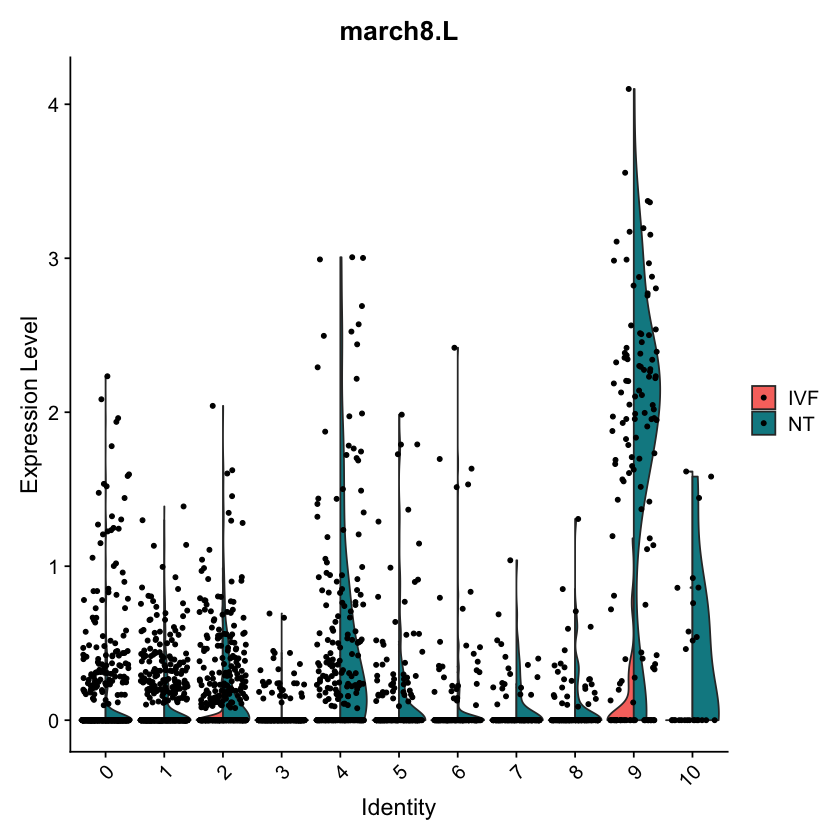

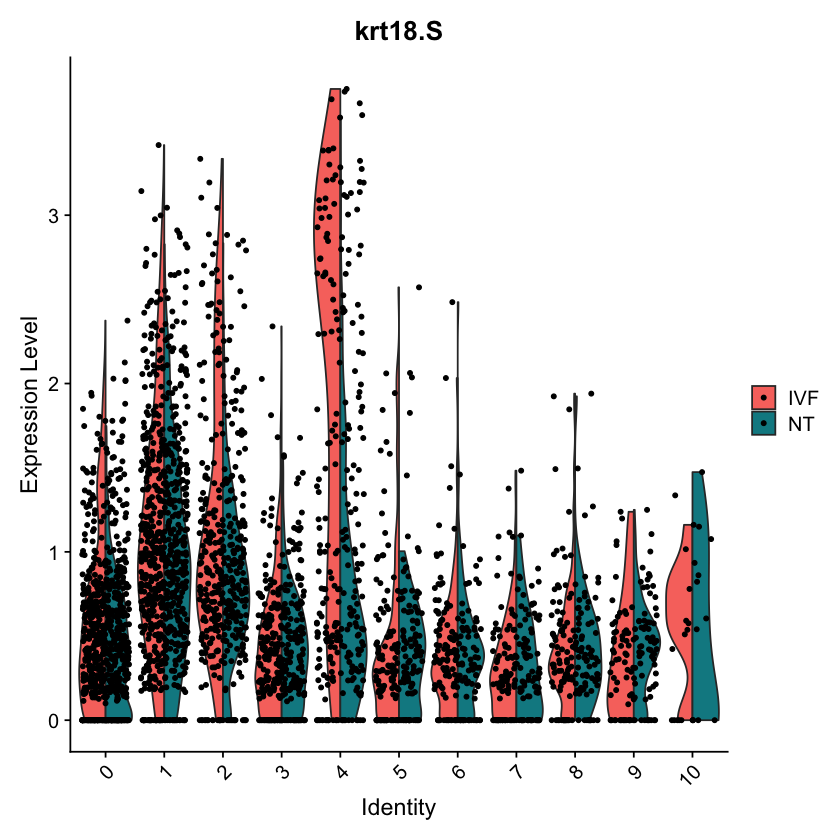

In [8]:
all.markers <- read.csv(file = '/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_total_DESeq2/res_tot.csv')

all.markers <- all.markers[all.markers['padj']<0.05,]

all.markers.pos<- all.markers[all.markers['log2FoldChange']>1,]
all.markers.neg<- all.markers[all.markers['log2FoldChange']< -1,]

VlnPlot(xenopus.combined, features = (all.markers.pos$X)[1] ,split.by='isnt')
VlnPlot(xenopus.combined, features = (all.markers.neg$X)[1] ,split.by='isnt')

In [10]:
colnames(all.markers.pos)[3]<- 'avg_logFC (NT/IVF)'
colnames(all.markers.neg)[3]<- 'avg_logFC (NT/IVF)'

write.csv(as.data.frame(all.markers.neg), file = "all_up_IVF.csv",row.names=TRUE)
write.csv(as.data.frame(all.markers.pos), file = "all_up_NT.csv",row.names=TRUE)

In [11]:
#Load the bulk data

import pandas as pd

bulk_data=pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/bulk_RNA_seq.csv")

bulk_data_donor = bulk_data[['Row.names','RPKM_donor1','RPKM_donor2','RPKM_donor3']]
bulk_data_donor = bulk_data_donor.set_index('Row.names')

new_names=[]

for i in list(bulk_data_donor.index):
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        new_names.append(lst[0])
    else:
        new_names.append(lst[1])

In [12]:
%get new_names

unique_new_names <- make.unique(new_names)

In [13]:
%get unique_new_names --from R

bulk_data_donor.index=unique_new_names

#Take the mean of the RPKM in the donor samples for each gene
bulk_data_donor_mean=bulk_data_donor.mean(axis=1)
bulk_data_donor_mean=bulk_data_donor_mean[bulk_data_donor_mean>1.0]

bulk_names=list(bulk_data_donor_mean.index)

In [14]:
print(len(list(bulk_data['Row.names'])),len(set(list(bulk_data['Row.names']))))

30736 30736


In [15]:
import pandas as pd

ON_mem_df=pd.read_csv('EndoNT_Filter_DonorsvsIVFdownFDR_DonsRPKM1_IVFvsNT_FDRup__OnMemFDR.csv')

ON_mem_old=list(ON_mem_df['Row.names'])

ON_mem_new=[]

for i in ON_mem_old:
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        ON_mem_new.append(lst[0])
    else:
        ON_mem_new.append(lst[1])
    

In [18]:
%get ON_mem_new
%get bulk_names

#Loop over the clusters
cl0.markers.pos <- read.csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_total_DESeq2/all_up_NT.csv",
                                    stringsAsFactors = FALSE)
    
#Tested genes: take the intersection with the genes with RPKM>1 in donor from bulk data
n <- length(intersect(Prefiltered.genes.tot,bulk_names))

#Consider only ON-memory genes present in the tested genes
ON.memory.genes <- intersect(Prefiltered.genes.tot,ON_mem_new)
print(c(n,length(ON.memory.genes)))

cl.list<- cl0.markers.pos$X
#Also for DE genes, consider only those with mean RPKM >1 in the donor samples from bulk data
cl.list<- intersect(cl.list,bulk_names)
                                
#Build contingency table
c.table <-matrix(c(n - length(union(cl.list,ON.memory.genes)), 
                           length(setdiff(cl.list,ON.memory.genes)),
                           length(setdiff(ON.memory.genes,cl.list)), 
                           length(intersect(cl.list,ON.memory.genes))),
                         nrow=2)
        
        
ON.mem.sc <- intersect(cl.list,ON.memory.genes)
#Perform Fisher test on the genes up in NT
ft <- fisher.test(c.table, alternative="greater")
print(c(length(cl.list),length(intersect(cl.list,ON.memory.genes))))
print(ft)
print("-----------------------------------------------------------")

DE.genes <- length(cl.list)
ON.mem.DE <- length(intersect(cl.list,ON.memory.genes))

#Fill the table with the results
print(c(n,length(ON.memory.genes),length(cl.list),length(intersect(cl.list,ON.memory.genes)),
       100*ON.mem.DE/DE.genes,ft$p.value))

[1] 15402  1069
[1] 96 14

	Fisher's Exact Test for Count Data

data:  c.table
p-value = 0.006321
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.337738      Inf
sample estimates:
odds ratio 
  2.306187 

[1] "-----------------------------------------------------------"
[1] 1.540200e+04 1.069000e+03 9.600000e+01 1.400000e+01 1.458333e+01
[6] 6.320596e-03


## Define in silico bulk ON-memory genes

In [19]:
import pandas as pd

bulk_data=pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/bulk_RNA_seq.csv")

bulk_data_donor = bulk_data[['Row.names','RPKM_donor1','RPKM_donor2','RPKM_donor3']]
bulk_data_donor = bulk_data_donor.set_index('Row.names')

new_names=[]

for i in list(bulk_data_donor.index):
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        new_names.append(lst[0])
    else:
        new_names.append(lst[1])

In [20]:
%get new_names

unique_new_names <- make.unique(new_names)

In [21]:
%get unique_new_names --from R

bulk_data_donor.index=unique_new_names

#Take the mean of the RPKM in the donor samples for each gene
bulk_data_donor_mean=bulk_data_donor.mean(axis=1)

In [22]:
print(len(list(bulk_data['Row.names'])),len(set(list(bulk_data['Row.names']))))

30736 30736


In [23]:
import collections
    
#Load genes up in NT cells in all cells
genes_up_NT = pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_total_DESeq2/all_up_NT.csv")
genes_up_NT=list(genes_up_NT['X'])
#print(genes_up_NT)
inters=list(set(genes_up_NT) & set(list(bulk_data_donor_mean.index)))
    
#Select only those that are expressed in the donor cells from the bulk data with RPKM>1
bulk_tmp=bulk_data_donor_mean.loc[inters]
#print(len(bulk_tmp.index),len(set(bulk_tmp.index)))
#print([item for item, count in collections.Counter(list(bulk_tmp.index)).items() if count > 1])
bulk_tmp=bulk_tmp[bulk_tmp>1.0]
    
#Append them to a list of lists of the newly defined ON-memory genes
in_silico_bulk_ON_memory=list(bulk_tmp.index)
print(len(genes_up_NT),len(inters),len(bulk_tmp.index))

116 116 96


The 96 genes are the in silico bulk ON-memory genes

In [48]:
genes_up_NT = pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_total_DESeq2/all_up_NT.csv")

In [49]:
genes_up_NT=genes_up_NT.iloc[:,1:]

In [51]:
genes_up_NT=genes_up_NT.set_index('X')

In [55]:
genes_up_NT=genes_up_NT.loc[list(in_silico_bulk_ON_memory),:]

In [57]:
genes_up_NT=genes_up_NT.sort_values('padj')

In [60]:
genes_up_NT.to_csv('in_silico_bulk_on_memory.csv')

In [26]:
import numpy as np
np.savetxt('in_silico_bulk_ON_memory.txt',np.c_[in_silico_bulk_ON_memory],fmt='%s')

# ON-memory genes intersections (OLD)

16/07/2020

We have 3 sets of ON-memory genes:
    
1. The ON-memory genes from bulk RNA-seq data (Hoermanseder et al, 2017)

2. The 'in silico bulk' ON-memory genes defined from the scRNA-seq data (from the DE analysis of IVF/NT without taking into account cluster labels)

3. The ON-memory genes defined at single-cell resolution (from the DE analysis of IVF/NT in each cluster)

In [29]:
#Load the data

#In silico bulk ON-memory
in_silico_bulk_ON_memory=np.loadtxt('/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_total_DESeq2/in_silico_bulk_ON_memory.txt',dtype=str)

#Bulk ON-memory
import pandas as pd

ON_mem_df=pd.read_csv('EndoNT_Filter_DonorsvsIVFdownFDR_DonsRPKM1_IVFvsNT_FDRup__OnMemFDR.csv')

ON_mem_old=list(ON_mem_df['Row.names'])

ON_mem_new=[]

for i in ON_mem_old:
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        ON_mem_new.append(lst[0])
    else:
        ON_mem_new.append(lst[1])
    
#ON-memory genes from the analysis in single clusters
single_cell_ON_memory=pd.read_csv('/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/ON_MEMORY_GENES/ON_memory_single_cell_definition.csv')    

single_cell_ON_memory=single_cell_ON_memory['Gene_name']

In [30]:
print(len(in_silico_bulk_ON_memory),len(ON_mem_new),len(single_cell_ON_memory))

96 1089 1399


In [33]:
inters1=set(in_silico_bulk_ON_memory) & set(ON_mem_new)
inters2=set(in_silico_bulk_ON_memory) & set(single_cell_ON_memory)
inters3=set(ON_mem_new) & set(single_cell_ON_memory)
inters4=set(in_silico_bulk_ON_memory) & set(ON_mem_new) & set(single_cell_ON_memory)

In [34]:
len(inters1),len(inters2),len(inters3),len(inters4)

(14, 96, 105, 14)

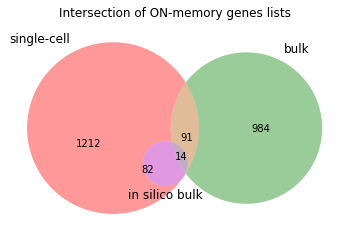

In [61]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
plt.figure()
plt.title('Intersection of ON-memory genes lists')
venn3([set(single_cell_ON_memory), set(ON_mem_new), set(in_silico_bulk_ON_memory)], 
      set_labels = ('single-cell', 'bulk', 'in silico bulk'))    
plt.savefig('Venn_ON_Memory_Genes.pdf')


# OLD Fisher test

In [27]:
# %get ON_mem_new
# %get bulk_names

# #print(length(ON_mem_new))

# #Consider only the ON memory genes present in the dataset


# #n <- length(rownames(xenopus.combined))

# clusters<- data.frame(table(Idents(xenopus.combined)))[['Var1']]

# ON.mem.sc <- rep(list(list()), length(clusters))

# clus.ids <- rep(list(),length(clusters))
# tested.genes <- rep(list(),length(clusters))
# ON.mem.length <- rep(list(),length(clusters))
# DE.genes <- rep(list(),length(clusters))
# ON.mem.DE <- rep(list(),length(clusters))
# perc <- rep(list(),length(clusters))
# pval <- rep(list(),length(clusters))

# #Loop over the clusters
# for(i in seq(1:length(clusters))){
    
#     # Select the results of the DE IVF/NT for cluster i
#     res <- results.DE[[i]]
    
#     # Define the significant genes up- or down- regulated in NT cells
#     res.sign <- res[res$padj <0.05]
#     res.up <- res.sign[res.sign$logFoldChange > 0]
#     res.down <- res.sign[res.sign$logFoldChange < 0]
    
#     cl0.markers.pos <- read.csv(paste("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/ClDE_up_NT_",(i-1),".csv",sep = ""),
#                                        stringsAsFactors = FALSE)
#     #VlnPlot(xenopus.combined, features = cl0.markers.pos$X[1] ,split.by='isnt')
    
#     #Tested genes: take the intersection with the genes with RPKM>1 in donor from bulk data
#     n <- length(intersect(rownames(res),bulk_names))
    
#     # Save the tested genes present in the bulk data
#     write.table(intersect(rownames(res),bulk_names),sep="",row.names=FALSE,col.names=FALSE, quote = FALSE,
#               file = paste("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/ON_MEMORY_GENES/tested_",(i-1),".txt",sep = ""))
    
#     #Consider only ON-memory genes present in the tested genes
#     ON.memory.genes <- intersect(rownames(res),ON_mem_new)
    
    
#     print(c(n,length(ON.memory.genes)))

#     cl.list<- rownames(res.up)
#     #Also for DE genes, consider only those with mean RPKM >1 in the donor samples from bulk data
#     cl.list<- intersect(cl.list,bulk_names)
    
#     # Save the ON-memory genes
#     write.table(cl.list,sep="",row.names=FALSE,col.names=FALSE, quote = FALSE,
#               file = paste("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/ON_MEMORY_GENES/sc_ON_memory_",(i-1),".txt",sep = ""))
                                
#     if(length(cl.list > 0)){
#         #Build contingency table
#         c.table <-matrix(c(n - length(union(cl.list,ON.memory.genes)), 
#                            length(setdiff(cl.list,ON.memory.genes)),
#                            length(setdiff(ON.memory.genes,cl.list)), 
#                            length(intersect(cl.list,ON.memory.genes))),
#                          nrow=2)
        
        
#         ON.mem.sc[[i]] <- intersect(cl.list,ON.memory.genes)
#         #Perform Fisher test on the genes up in NT
#         ft <- fisher.test(c.table, alternative="greater")
#         print(cat("Cluster",(i-1),"\n"))
#         print(c(length(cl.list),length(intersect(cl.list,ON.memory.genes))))
#         print(ft)
#         print("-----------------------------------------------------------")
#     }else{
#         print(cat("Cluster", (i-1), "has not genes up in NT\n"))
#         print("-----------------------------------------------------------")
#     }
#     #Fill the table with the results
#     clus.ids[[i]] <- i-1
#     tested.genes[[i]] <- n
#     ON.mem.length[[i]] <- length(ON.memory.genes)
#     DE.genes[[i]] <- length(cl.list)
#     ON.mem.DE[[i]] <- length(intersect(cl.list,ON.memory.genes))
#     perc[[i]] <- 100*ON.mem.DE[[i]]/DE.genes[[i]]
#     pval[[i]] <- ft$p.value
    
    
# }

# results.df <- do.call(rbind.data.frame, Map('c',clus.ids, tested.genes,ON.mem.length,DE.genes,ON.mem.DE,perc,pval ))

# # results.df <- data.frame("Tested_genes" = tested.genes, "ON_mem_in_tested" = ON.mem.length,
# #                          "DE_genes_up_NT" = DE.genes,"inters_DE_ON_mem" = ON.mem.DE,"perc" = perc,
# #                         "Fisher_pval"= pval)

[1] 14064   985
Cluster 0 
NULL
[1] 74 10

	Fisher's Exact Test for Count Data

data:  c.table
p-value = 0.03292
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.082037      Inf
sample estimates:
odds ratio 
  2.085589 

[1] "-----------------------------------------------------------"
[1] 14271   983
Cluster 1 
NULL
[1] 64  5

	Fisher's Exact Test for Count Data

data:  c.table
p-value = 0.4533
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.4359533       Inf
sample estimates:
odds ratio 
  1.146308 

[1] "-----------------------------------------------------------"
[1] 14000   959
Cluster 2 
NULL
[1] 38  2

	Fisher's Exact Test for Count Data

data:  c.table
p-value = 0.7445
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.1292165       Inf
sample estimates:
odds ratio 
 0.7549644 

[1] "-----------------------------------------------------------"
[1] 1

In [ ]:
sessionInfo()